# Effective Kraus Rank Analysis

In [2]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Dissipative part

In [17]:
n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model1 = KrausMap(
                        d = d, 
                        rank = 3,
                        )


U = generate_unitary(d=d)

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model2 = KrausMap(U = U,
                        c = 0.5,
                        d = d, 
                        rank = 3,
                        )

In [18]:
print(effective_rank(kraus_model1))
print(effective_rank(kraus_model2))

tf.Tensor((2.913370242359223+9.117136601779725e-18j), shape=(), dtype=complex128)
tf.Tensor((2.9556278011471173+1.5125059991596288e-16j), shape=(), dtype=complex128)


In [11]:
2*(2.9556278011471173 - 1)

3.9112556022942346

## Additivity

In [25]:
n = 3
d = 2**n

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

rank_eff_mult = []
rank_eff_add = []
rank_list = list(range(1,32))

for rank in tqdm(rank_list):

    kraus_model1 = KrausMap(
                           d = d, 
                           rank = rank,
                           )

    kraus_model2 = KrausMap(
                           d = d, 
                           rank = rank,
                           )
    choi = maps_to_choi([kraus_model1, kraus_model2])

    rank1 = effective_rank(kraus_model1)
    rank2 = effective_rank(kraus_model2)
    rank3 = effective_rank(choi)
    
    rank_eff_mult.append(rank1*rank2)
    rank_eff_add.append(rank3)

  0%|          | 0/31 [00:00<?, ?it/s]

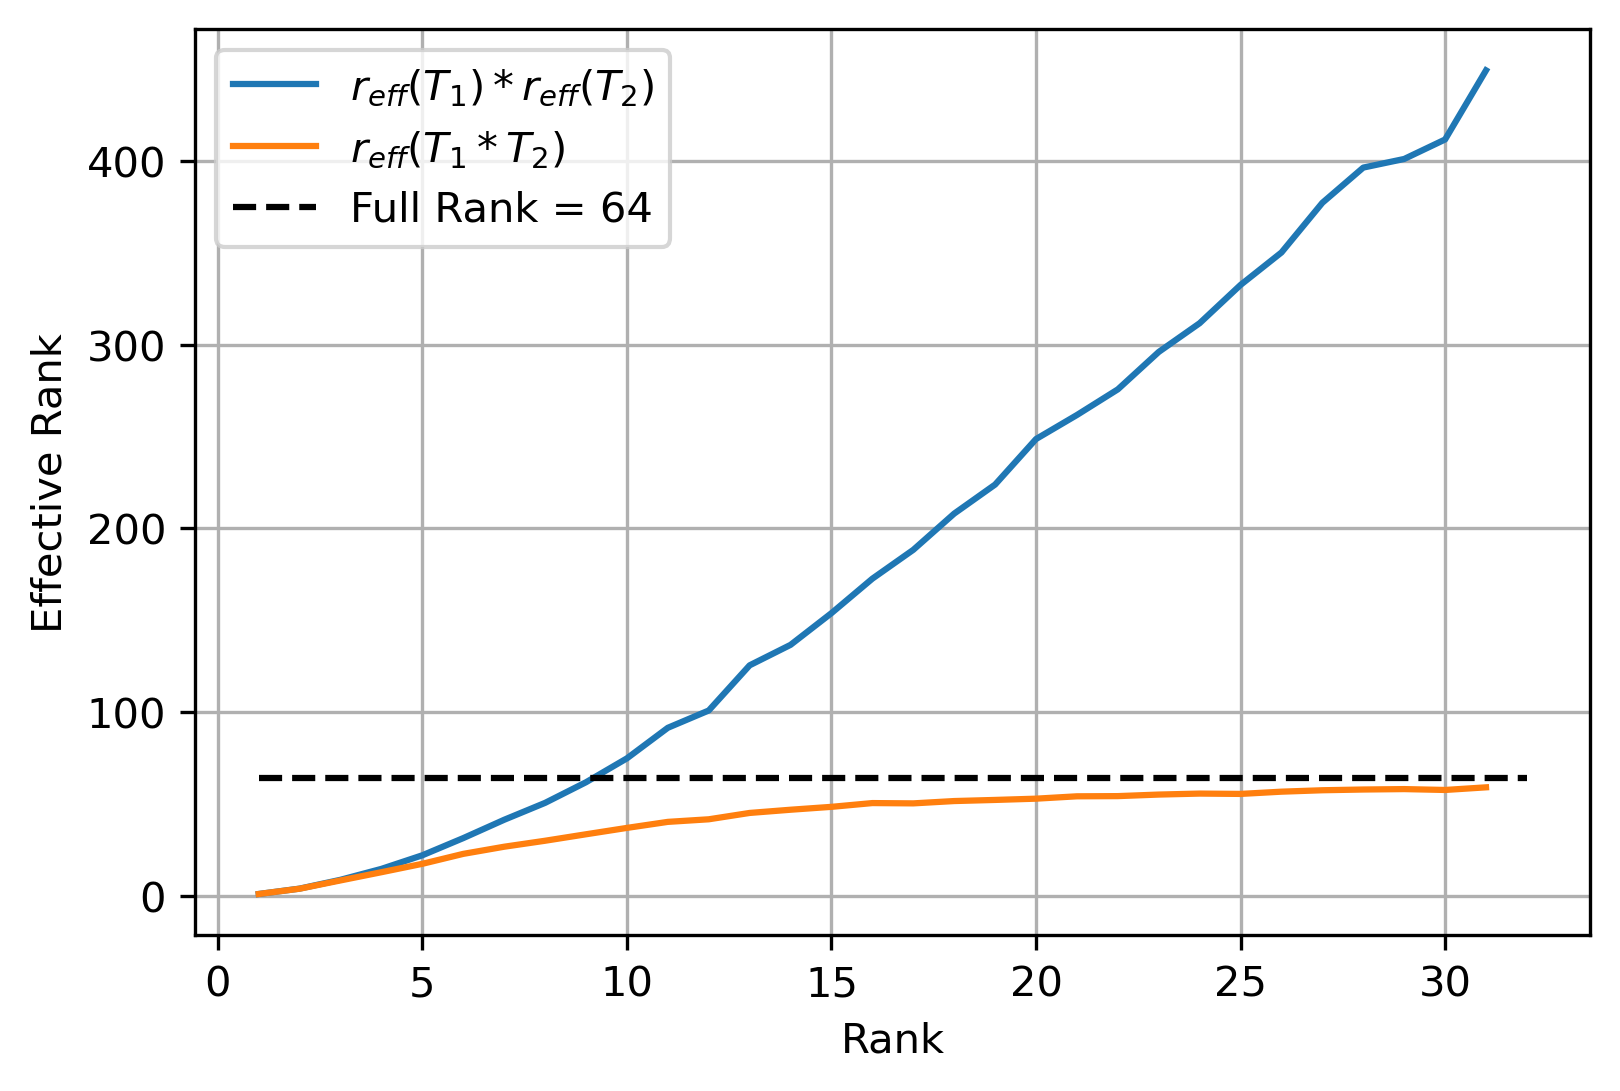

In [29]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(rank_list, rank_eff_mult)
plt.plot(rank_list, rank_eff_add)
plt.plot([1, 32], [64, 64], "k--")
plt.legend(["$r_{eff}(T_1)*r_{eff}(T_2)$", "$r_{eff}(T_1*T_2)$", "Full Rank = 64"])
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.grid()
plt.show()

In [21]:
n = 4
d = 2**n

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

rank_eff_mult = []
rank_eff_add = []
rank_list = list(range(1,32))

for rank in tqdm(rank_list):

    kraus_model1 = KrausMap(
                           d = d, 
                           rank = rank,
                           )

    kraus_model2 = KrausMap(
                           d = d, 
                           rank = rank,
                           )
    choi = maps_to_choi([kraus_model1, kraus_model2])

    rank1 = effective_rank(kraus_model1)
    rank2 = effective_rank(kraus_model2)
    rank3 = effective_rank(choi)
    
    rank_eff_mult.append(rank1*rank2)
    rank_eff_add.append(rank3)

  0%|          | 0/31 [00:00<?, ?it/s]

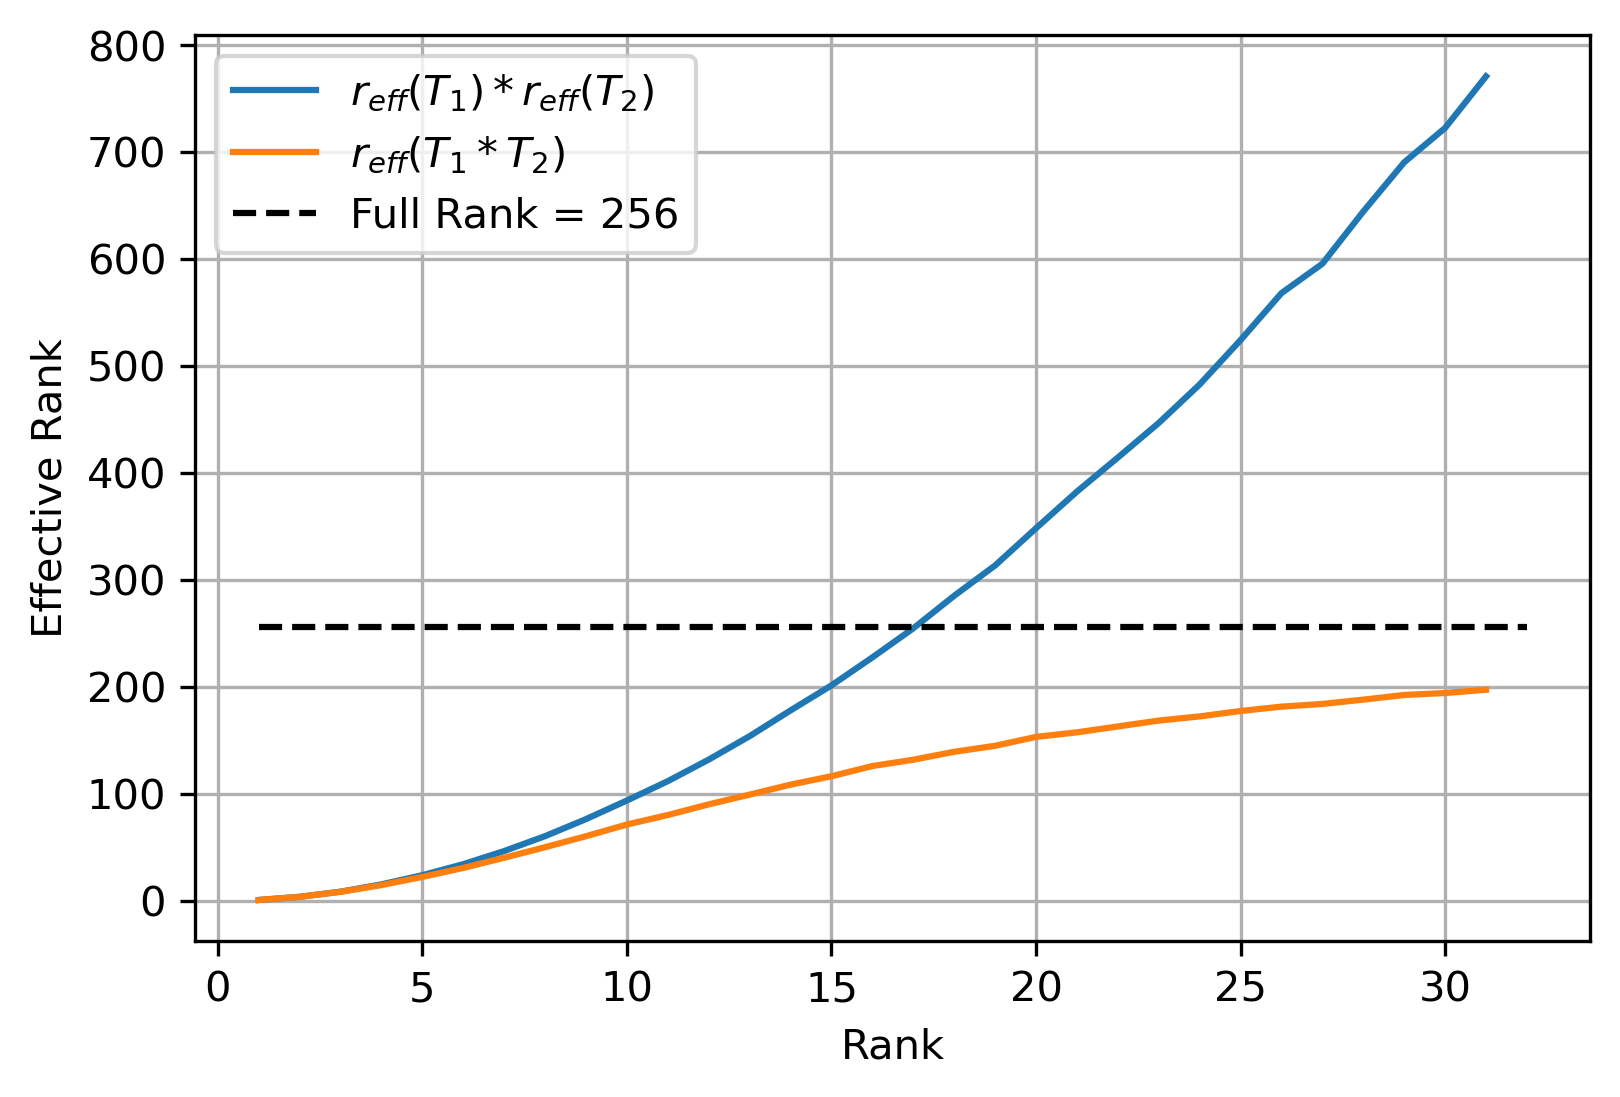

In [24]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(rank_list, rank_eff_mult)
plt.plot(rank_list, rank_eff_add)
plt.plot([1, 32], [256, 256], "k--")
plt.legend(["$r_{eff}(T_1)*r_{eff}(T_2)$", "$r_{eff}(T_1*T_2)$", "Full Rank = 256"])
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.grid()
plt.show()

### Exponentiated

In [29]:
n = 4
d = 2**n

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)



kraus_model = KrausMap(d = d, 
                       rank = 2,
                       )

choi = maps_to_choi([kraus_model])
rank_eff_basis = effective_rank(choi)

rank_eff_est = []
rank_eff_exp = []
rank_list = list(range(1, 17))

for rank in tqdm(rank_list):
    
    choi = maps_to_choi(rank*[kraus_model])
    
    rank_eff_est.append(rank_eff_basis**rank)
    
    rank_eff = effective_rank(choi)
    rank_eff_exp.append(rank_eff)

  0%|          | 0/16 [00:00<?, ?it/s]

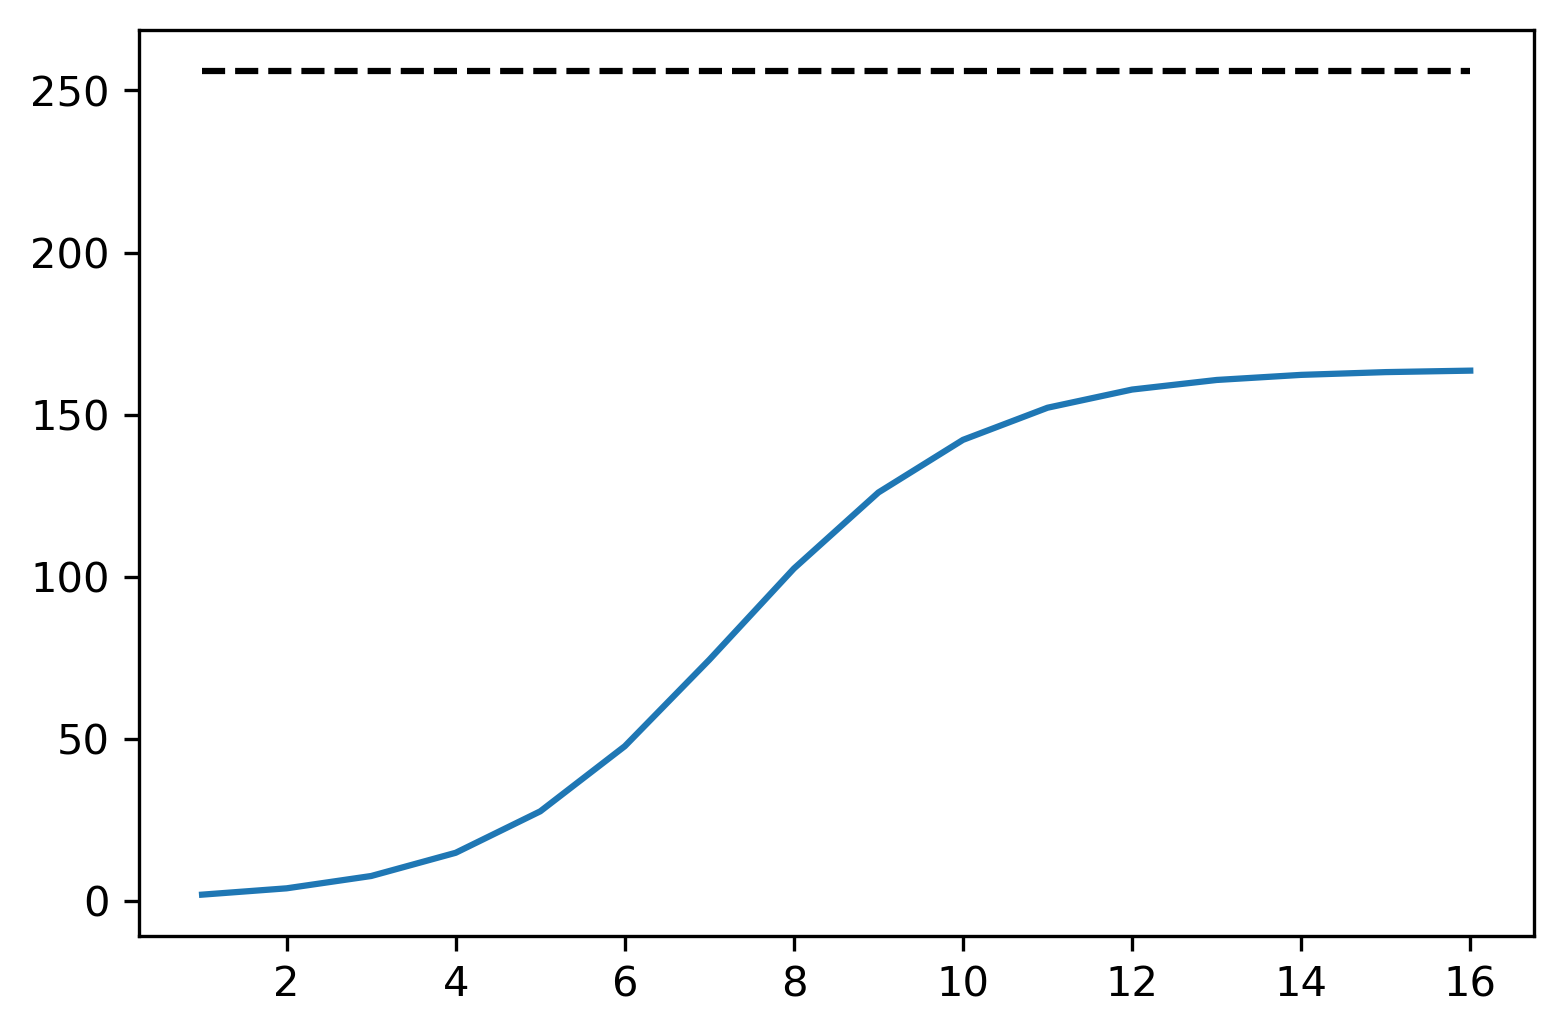

In [30]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(rank_list, rank_eff_exp)
#plt.plot(rank_list, rank_eff_est)
plt.plot([1, 16], [256, 256], "k--")
#plt.yscale("log")
plt.show()

Exponentiation saturates the rank 

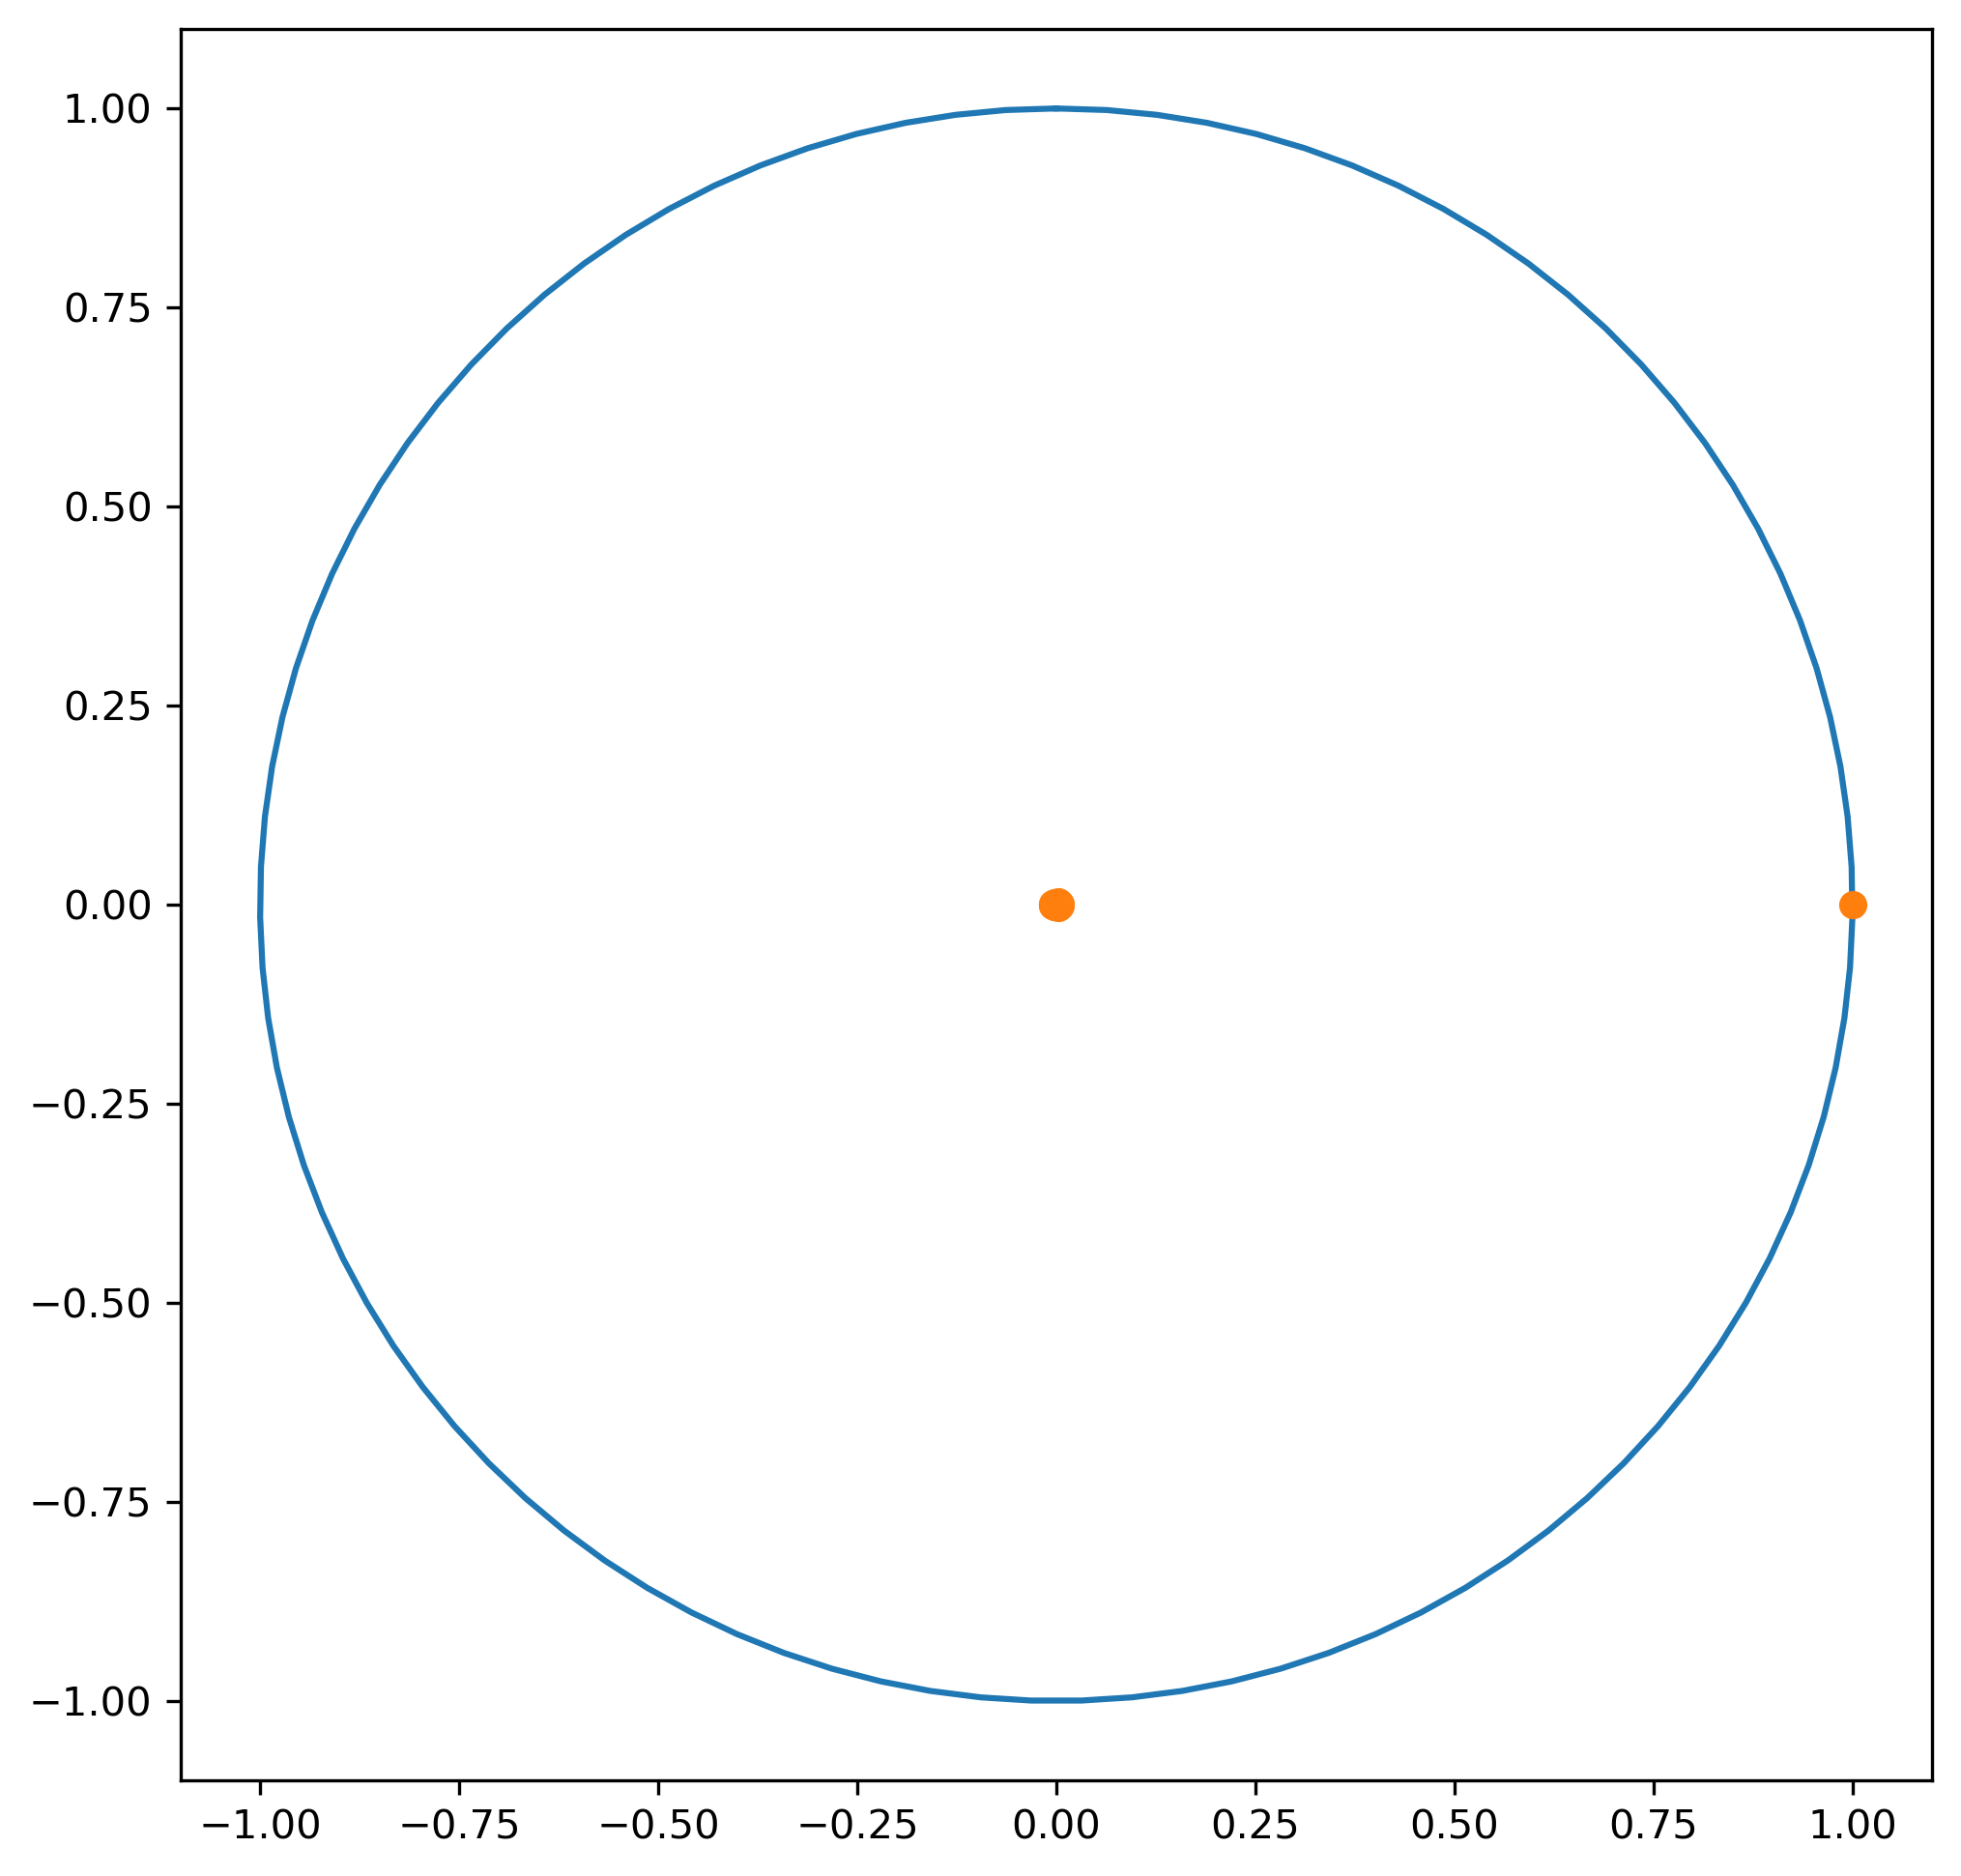

In [31]:
spectrum = choi_spectrum(choi)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(spectrum[:,0], spectrum[:,1], "o")
plt.show()

# Effective Rank Heuristic

In [10]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 2
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(10):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/10)

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_9584\3407845712.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020A2AF84790> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Analytical", "Rank_eff = 8"])


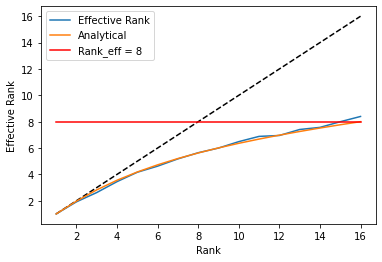

In [14]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Analytical", "Rank_eff = 8"])
plt.show()

In [19]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(10):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/10)

  0%|          | 0/64 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_9584\2886972908.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020A2C4E4250> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 32"])


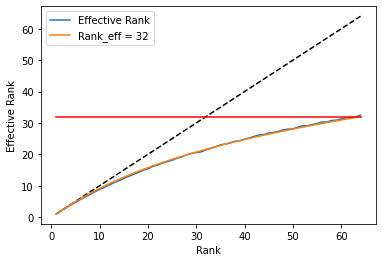

In [20]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 32"])
plt.show()

In [21]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 4
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(1):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff)

  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_9584\3647835032.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020A2CAD53F0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 128"])


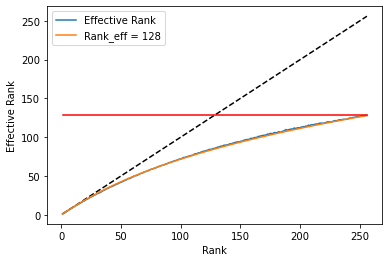

In [29]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 128"])
plt.show()

## Map Inflation

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n

kraus_1 = KrausMap(d = d, 
                   rank = d**2)

model_1 = ModelQuantumMap(
                          q_map = kraus_1,
                          loss = RankShrink(inflate=False),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01),
                         )

kraus_2 = KrausMap(d = d, 
                   rank = d**2)

model_2 = ModelQuantumMap(
                          q_map = kraus_2,
                          loss = RankShrink(inflate=True),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01),
                          )

print(effective_rank(kraus_1))
print(effective_rank(kraus_2))

tf.Tensor((32.14313513586344+2.3712512433770163e-16j), shape=(), dtype=complex128)
tf.Tensor((32.46069762650621-3.541595186096593e-16j), shape=(), dtype=complex128)


In [3]:
model_1.train(inputs = [],
                    targets = [],
                    num_iter = 1000,
                    verbose = True,
                    use_batch = False,
                   )

model_2.train(inputs = [],
              targets = [],
              num_iter = 1000,
              verbose = True,
              use_batch = False,
                   )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 32.14314, val: 0.00000
Step:1, train: 31.62910, val: 0.00000
Step:2, train: 31.11587, val: 0.00000
Step:3, train: 30.60398, val: 0.00000
Step:4, train: 30.09397, val: 0.00000
Step:5, train: 29.58606, val: 0.00000
Step:6, train: 29.08083, val: 0.00000
Step:7, train: 28.57875, val: 0.00000
Step:8, train: 28.08022, val: 0.00000
Step:9, train: 27.58570, val: 0.00000
Step:10, train: 27.09533, val: 0.00000
Step:11, train: 26.60942, val: 0.00000
Step:12, train: 26.12845, val: 0.00000
Step:13, train: 25.65229, val: 0.00000
Step:14, train: 25.18116, val: 0.00000
Step:15, train: 24.71527, val: 0.00000
Step:16, train: 24.25508, val: 0.00000
Step:17, train: 23.80058, val: 0.00000
Step:18, train: 23.35100, val: 0.00000
Step:19, train: 22.90802, val: 0.00000
Step:20, train: 22.47092, val: 0.00000
Step:21, train: 22.03985, val: 0.00000
Step:22, train: 21.61431, val: 0.00000
Step:23, train: 21.19472, val: 0.00000
Step:24, train: 20.78135, val: 0.00000
Step:25, train: 20.37450, val: 0.00

Step:212, train: 2.53204, val: 0.00000
Step:213, train: 2.52192, val: 0.00000
Step:214, train: 2.51192, val: 0.00000
Step:215, train: 2.50202, val: 0.00000
Step:216, train: 2.49223, val: 0.00000
Step:217, train: 2.48254, val: 0.00000
Step:218, train: 2.47296, val: 0.00000
Step:219, train: 2.46348, val: 0.00000
Step:220, train: 2.45410, val: 0.00000
Step:221, train: 2.44482, val: 0.00000
Step:222, train: 2.43564, val: 0.00000
Step:223, train: 2.42656, val: 0.00000
Step:224, train: 2.41756, val: 0.00000
Step:225, train: 2.40867, val: 0.00000
Step:226, train: 2.39986, val: 0.00000
Step:227, train: 2.39114, val: 0.00000
Step:228, train: 2.38251, val: 0.00000
Step:229, train: 2.37397, val: 0.00000
Step:230, train: 2.36552, val: 0.00000
Step:231, train: 2.35715, val: 0.00000
Step:232, train: 2.34886, val: 0.00000
Step:233, train: 2.34066, val: 0.00000
Step:234, train: 2.33253, val: 0.00000
Step:235, train: 2.32449, val: 0.00000
Step:236, train: 2.31652, val: 0.00000
Step:237, train: 2.30863,

Step:424, train: 1.53766, val: 0.00000
Step:425, train: 1.53550, val: 0.00000
Step:426, train: 1.53334, val: 0.00000
Step:427, train: 1.53119, val: 0.00000
Step:428, train: 1.52905, val: 0.00000
Step:429, train: 1.52693, val: 0.00000
Step:430, train: 1.52481, val: 0.00000
Step:431, train: 1.52270, val: 0.00000
Step:432, train: 1.52061, val: 0.00000
Step:433, train: 1.51853, val: 0.00000
Step:434, train: 1.51645, val: 0.00000
Step:435, train: 1.51439, val: 0.00000
Step:436, train: 1.51233, val: 0.00000
Step:437, train: 1.51029, val: 0.00000
Step:438, train: 1.50825, val: 0.00000
Step:439, train: 1.50623, val: 0.00000
Step:440, train: 1.50421, val: 0.00000
Step:441, train: 1.50221, val: 0.00000
Step:442, train: 1.50021, val: 0.00000
Step:443, train: 1.49823, val: 0.00000
Step:444, train: 1.49625, val: 0.00000
Step:445, train: 1.49429, val: 0.00000
Step:446, train: 1.49233, val: 0.00000
Step:447, train: 1.49038, val: 0.00000
Step:448, train: 1.48844, val: 0.00000
Step:449, train: 1.48651,

Step:636, train: 1.23866, val: 0.00000
Step:637, train: 1.23776, val: 0.00000
Step:638, train: 1.23687, val: 0.00000
Step:639, train: 1.23599, val: 0.00000
Step:640, train: 1.23510, val: 0.00000
Step:641, train: 1.23423, val: 0.00000
Step:642, train: 1.23335, val: 0.00000
Step:643, train: 1.23248, val: 0.00000
Step:644, train: 1.23161, val: 0.00000
Step:645, train: 1.23074, val: 0.00000
Step:646, train: 1.22988, val: 0.00000
Step:647, train: 1.22902, val: 0.00000
Step:648, train: 1.22816, val: 0.00000
Step:649, train: 1.22731, val: 0.00000
Step:650, train: 1.22646, val: 0.00000
Step:651, train: 1.22561, val: 0.00000
Step:652, train: 1.22476, val: 0.00000
Step:653, train: 1.22392, val: 0.00000
Step:654, train: 1.22309, val: 0.00000
Step:655, train: 1.22225, val: 0.00000
Step:656, train: 1.22142, val: 0.00000
Step:657, train: 1.22059, val: 0.00000
Step:658, train: 1.21977, val: 0.00000
Step:659, train: 1.21895, val: 0.00000
Step:660, train: 1.21813, val: 0.00000
Step:661, train: 1.21731,

Step:848, train: 1.10784, val: 0.00000
Step:849, train: 1.10743, val: 0.00000
Step:850, train: 1.10703, val: 0.00000
Step:851, train: 1.10663, val: 0.00000
Step:852, train: 1.10623, val: 0.00000
Step:853, train: 1.10584, val: 0.00000
Step:854, train: 1.10544, val: 0.00000
Step:855, train: 1.10505, val: 0.00000
Step:856, train: 1.10465, val: 0.00000
Step:857, train: 1.10426, val: 0.00000
Step:858, train: 1.10387, val: 0.00000
Step:859, train: 1.10348, val: 0.00000
Step:860, train: 1.10310, val: 0.00000
Step:861, train: 1.10271, val: 0.00000
Step:862, train: 1.10233, val: 0.00000
Step:863, train: 1.10195, val: 0.00000
Step:864, train: 1.10156, val: 0.00000
Step:865, train: 1.10118, val: 0.00000
Step:866, train: 1.10081, val: 0.00000
Step:867, train: 1.10043, val: 0.00000
Step:868, train: 1.10005, val: 0.00000
Step:869, train: 1.09968, val: 0.00000
Step:870, train: 1.09931, val: 0.00000
Step:871, train: 1.09894, val: 0.00000
Step:872, train: 1.09857, val: 0.00000
Step:873, train: 1.09820,

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 32.46070, val: 0.00000
Step:1, train: 32.97348, val: 0.00000
Step:2, train: 33.48616, val: 0.00000
Step:3, train: 33.99827, val: 0.00000
Step:4, train: 34.50943, val: 0.00000
Step:5, train: 35.01911, val: 0.00000
Step:6, train: 35.52701, val: 0.00000
Step:7, train: 36.03262, val: 0.00000
Step:8, train: 36.53557, val: 0.00000
Step:9, train: 37.03550, val: 0.00000
Step:10, train: 37.53212, val: 0.00000
Step:11, train: 38.02522, val: 0.00000
Step:12, train: 38.51435, val: 0.00000
Step:13, train: 38.99945, val: 0.00000
Step:14, train: 39.48076, val: 0.00000
Step:15, train: 39.95766, val: 0.00000
Step:16, train: 40.43052, val: 0.00000
Step:17, train: 40.89949, val: 0.00000
Step:18, train: 41.36421, val: 0.00000
Step:19, train: 41.82458, val: 0.00000
Step:20, train: 42.27991, val: 0.00000
Step:21, train: 42.73148, val: 0.00000
Step:22, train: 43.17832, val: 0.00000
Step:23, train: 43.62045, val: 0.00000
Step:24, train: 44.05756, val: 0.00000
Step:25, train: 44.49015, val: 0.00

Step:209, train: 63.98899, val: 0.00000
Step:210, train: 63.98920, val: 0.00000
Step:211, train: 63.98933, val: 0.00000
Step:212, train: 63.98938, val: 0.00000
Step:213, train: 63.98957, val: 0.00000
Step:214, train: 63.98969, val: 0.00000
Step:215, train: 63.98979, val: 0.00000
Step:216, train: 63.98985, val: 0.00000
Step:217, train: 63.98999, val: 0.00000
Step:218, train: 63.99008, val: 0.00000
Step:219, train: 63.99012, val: 0.00000
Step:220, train: 63.99011, val: 0.00000
Step:221, train: 63.99018, val: 0.00000
Step:222, train: 63.99018, val: 0.00000
Step:223, train: 63.99014, val: 0.00000
Step:224, train: 63.99015, val: 0.00000
Step:225, train: 63.99021, val: 0.00000
Step:226, train: 63.99030, val: 0.00000
Step:227, train: 63.99039, val: 0.00000
Step:228, train: 63.99062, val: 0.00000
Step:229, train: 63.99090, val: 0.00000
Step:230, train: 63.99114, val: 0.00000
Step:231, train: 63.99125, val: 0.00000
Step:232, train: 63.99124, val: 0.00000
Step:233, train: 63.99134, val: 0.00000


Step:415, train: 63.98990, val: 0.00000
Step:416, train: 63.98978, val: 0.00000
Step:417, train: 63.98967, val: 0.00000
Step:418, train: 63.98961, val: 0.00000
Step:419, train: 63.98959, val: 0.00000
Step:420, train: 63.98958, val: 0.00000
Step:421, train: 63.98957, val: 0.00000
Step:422, train: 63.98952, val: 0.00000
Step:423, train: 63.98943, val: 0.00000
Step:424, train: 63.98930, val: 0.00000
Step:425, train: 63.98915, val: 0.00000
Step:426, train: 63.98898, val: 0.00000
Step:427, train: 63.98881, val: 0.00000
Step:428, train: 63.98867, val: 0.00000
Step:429, train: 63.98856, val: 0.00000
Step:430, train: 63.98846, val: 0.00000
Step:431, train: 63.98837, val: 0.00000
Step:432, train: 63.98826, val: 0.00000
Step:433, train: 63.98842, val: 0.00000
Step:434, train: 63.98849, val: 0.00000
Step:435, train: 63.98845, val: 0.00000
Step:436, train: 63.98833, val: 0.00000
Step:437, train: 63.98813, val: 0.00000
Step:438, train: 63.98810, val: 0.00000
Step:439, train: 63.98808, val: 0.00000


KeyboardInterrupt: 

In [5]:
print(effective_rank(kraus_1))
print(effective_rank(kraus_2))

tf.Tensor((1.0610211143516128-1.4732517689133798e-16j), shape=(), dtype=complex128)
tf.Tensor((63.98429510236448+1.2693983439100066e-15j), shape=(), dtype=complex128)


C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


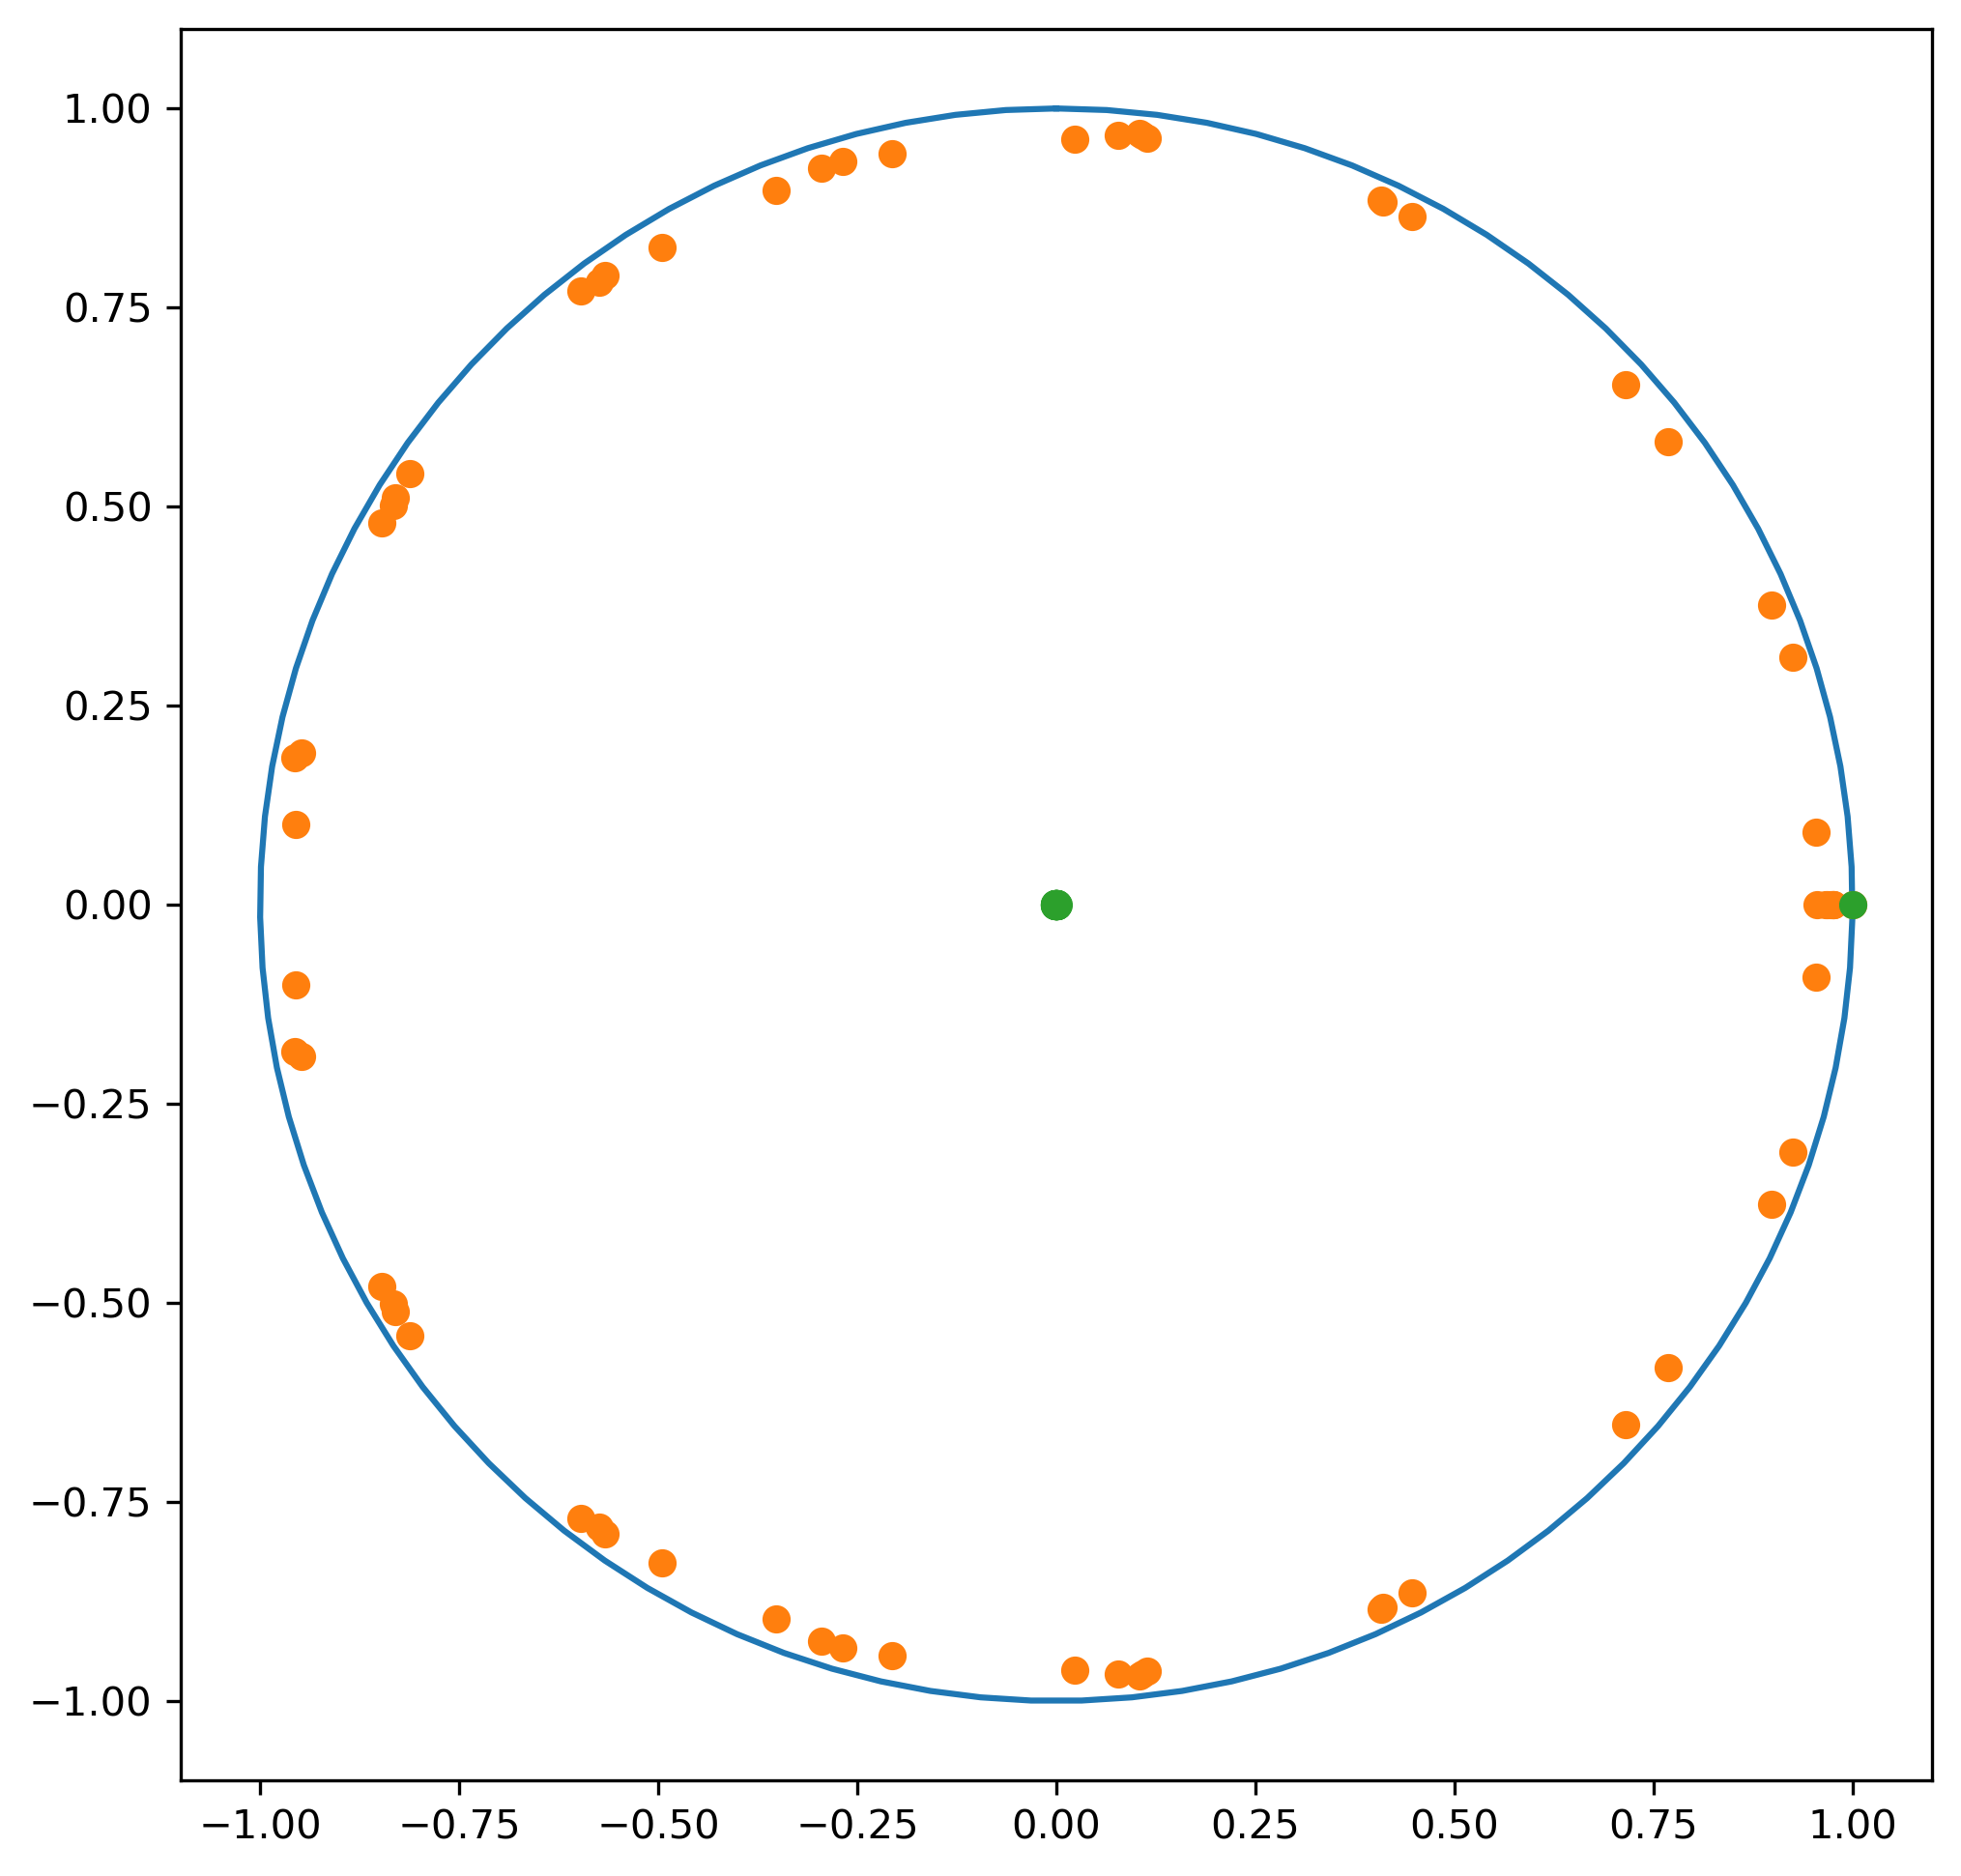

In [7]:
choi1 = kraus_to_choi(kraus_1)
spectrum_1 = choi_spectrum(choi1)

choi2 = kraus_to_choi(kraus_2)
spectrum_2 = choi_spectrum(choi2)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(spectrum_1[:,0], spectrum_1[:,1], "o")
plt.plot(spectrum_2[:,0], spectrum_2[:,1], "o")
plt.show()

## Deflated Ring

In [30]:
def ringify_spectrum(spectrum):
    spectrum = spectrum/tf.linalg.norm(spectrum, axis = 1, keepdims=True)
    return spectrum

In [35]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n

kraus_target = KrausMap(d = d, 
                        rank = d**2)

spectrum_target= choi_spectrum(kraus_to_choi(kraus_target))
spectrum_target = 1/d*ringify_spectrum(spectrum_target)

kraus_model = KrausMap(d = d, 
                       rank = d**2)

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = SpectrumDistance(sigma=1, k=100),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [36]:
model.train(inputs = [spectrum_target],
            targets = [],
            num_iter = 1000,
            N = 1,
            use_batch=False,
            verbose=True,
           )

  0%|          | 0/2000 [00:00<?, ?it/s]

Step:0, train: 0.00015, val: 0.00000
Step:1, train: 0.00014, val: 0.00000
Step:2, train: 0.00013, val: 0.00000
Step:3, train: 0.00013, val: 0.00000
Step:4, train: 0.00012, val: 0.00000
Step:5, train: 0.00012, val: 0.00000
Step:6, train: 0.00012, val: 0.00000
Step:7, train: 0.00012, val: 0.00000
Step:8, train: 0.00012, val: 0.00000
Step:9, train: 0.00012, val: 0.00000
Step:10, train: 0.00012, val: 0.00000
Step:11, train: 0.00012, val: 0.00000
Step:12, train: 0.00012, val: 0.00000
Step:13, train: 0.00013, val: 0.00000
Step:14, train: 0.00013, val: 0.00000
Step:15, train: 0.00013, val: 0.00000
Step:16, train: 0.00013, val: 0.00000
Step:17, train: 0.00013, val: 0.00000
Step:18, train: 0.00013, val: 0.00000
Step:19, train: 0.00013, val: 0.00000
Step:20, train: 0.00013, val: 0.00000
Step:21, train: 0.00013, val: 0.00000
Step:22, train: 0.00013, val: 0.00000
Step:23, train: 0.00013, val: 0.00000
Step:24, train: 0.00013, val: 0.00000
Step:25, train: 0.00013, val: 0.00000
Step:26, train: 0.0001

Step:214, train: 0.00039, val: 0.00000
Step:215, train: 0.00039, val: 0.00000
Step:216, train: 0.00039, val: 0.00000
Step:217, train: 0.00040, val: 0.00000
Step:218, train: 0.00040, val: 0.00000
Step:219, train: 0.00040, val: 0.00000
Step:220, train: 0.00040, val: 0.00000
Step:221, train: 0.00040, val: 0.00000
Step:222, train: 0.00040, val: 0.00000
Step:223, train: 0.00040, val: 0.00000
Step:224, train: 0.00040, val: 0.00000
Step:225, train: 0.00040, val: 0.00000
Step:226, train: 0.00040, val: 0.00000
Step:227, train: 0.00040, val: 0.00000
Step:228, train: 0.00041, val: 0.00000
Step:229, train: 0.00041, val: 0.00000
Step:230, train: 0.00041, val: 0.00000
Step:231, train: 0.00041, val: 0.00000
Step:232, train: 0.00041, val: 0.00000
Step:233, train: 0.00041, val: 0.00000
Step:234, train: 0.00041, val: 0.00000
Step:235, train: 0.00041, val: 0.00000
Step:236, train: 0.00041, val: 0.00000
Step:237, train: 0.00041, val: 0.00000
Step:238, train: 0.00041, val: 0.00000
Step:239, train: 0.00042,

Step:426, train: 0.00052, val: 0.00000
Step:427, train: 0.00052, val: 0.00000
Step:428, train: 0.00052, val: 0.00000
Step:429, train: 0.00052, val: 0.00000
Step:430, train: 0.00053, val: 0.00000
Step:431, train: 0.00053, val: 0.00000
Step:432, train: 0.00053, val: 0.00000
Step:433, train: 0.00053, val: 0.00000
Step:434, train: 0.00053, val: 0.00000
Step:435, train: 0.00053, val: 0.00000
Step:436, train: 0.00053, val: 0.00000
Step:437, train: 0.00053, val: 0.00000
Step:438, train: 0.00053, val: 0.00000
Step:439, train: 0.00053, val: 0.00000
Step:440, train: 0.00053, val: 0.00000
Step:441, train: 0.00053, val: 0.00000
Step:442, train: 0.00053, val: 0.00000
Step:443, train: 0.00053, val: 0.00000
Step:444, train: 0.00053, val: 0.00000
Step:445, train: 0.00053, val: 0.00000
Step:446, train: 0.00053, val: 0.00000
Step:447, train: 0.00053, val: 0.00000
Step:448, train: 0.00053, val: 0.00000
Step:449, train: 0.00053, val: 0.00000
Step:450, train: 0.00053, val: 0.00000
Step:451, train: 0.00053,

Step:638, train: 0.00058, val: 0.00000
Step:639, train: 0.00058, val: 0.00000
Step:640, train: 0.00058, val: 0.00000
Step:641, train: 0.00058, val: 0.00000
Step:642, train: 0.00058, val: 0.00000
Step:643, train: 0.00058, val: 0.00000
Step:644, train: 0.00058, val: 0.00000
Step:645, train: 0.00058, val: 0.00000
Step:646, train: 0.00058, val: 0.00000
Step:647, train: 0.00058, val: 0.00000
Step:648, train: 0.00058, val: 0.00000
Step:649, train: 0.00058, val: 0.00000
Step:650, train: 0.00058, val: 0.00000
Step:651, train: 0.00058, val: 0.00000
Step:652, train: 0.00058, val: 0.00000
Step:653, train: 0.00058, val: 0.00000
Step:654, train: 0.00058, val: 0.00000
Step:655, train: 0.00058, val: 0.00000
Step:656, train: 0.00058, val: 0.00000
Step:657, train: 0.00058, val: 0.00000
Step:658, train: 0.00058, val: 0.00000
Step:659, train: 0.00058, val: 0.00000
Step:660, train: 0.00058, val: 0.00000
Step:661, train: 0.00058, val: 0.00000
Step:662, train: 0.00058, val: 0.00000
Step:663, train: 0.00059,

Step:850, train: 0.00062, val: 0.00000
Step:851, train: 0.00062, val: 0.00000
Step:852, train: 0.00062, val: 0.00000
Step:853, train: 0.00062, val: 0.00000
Step:854, train: 0.00062, val: 0.00000
Step:855, train: 0.00062, val: 0.00000
Step:856, train: 0.00062, val: 0.00000
Step:857, train: 0.00062, val: 0.00000
Step:858, train: 0.00062, val: 0.00000
Step:859, train: 0.00062, val: 0.00000
Step:860, train: 0.00062, val: 0.00000
Step:861, train: 0.00062, val: 0.00000
Step:862, train: 0.00062, val: 0.00000
Step:863, train: 0.00062, val: 0.00000
Step:864, train: 0.00062, val: 0.00000
Step:865, train: 0.00062, val: 0.00000
Step:866, train: 0.00062, val: 0.00000
Step:867, train: 0.00062, val: 0.00000
Step:868, train: 0.00062, val: 0.00000
Step:869, train: 0.00062, val: 0.00000
Step:870, train: 0.00062, val: 0.00000
Step:871, train: 0.00062, val: 0.00000
Step:872, train: 0.00062, val: 0.00000
Step:873, train: 0.00062, val: 0.00000
Step:874, train: 0.00062, val: 0.00000
Step:875, train: 0.00062,

Step:1060, train: 0.00064, val: 0.00000
Step:1061, train: 0.00064, val: 0.00000
Step:1062, train: 0.00064, val: 0.00000
Step:1063, train: 0.00064, val: 0.00000
Step:1064, train: 0.00064, val: 0.00000
Step:1065, train: 0.00064, val: 0.00000
Step:1066, train: 0.00064, val: 0.00000
Step:1067, train: 0.00064, val: 0.00000
Step:1068, train: 0.00064, val: 0.00000
Step:1069, train: 0.00064, val: 0.00000
Step:1070, train: 0.00064, val: 0.00000
Step:1071, train: 0.00064, val: 0.00000
Step:1072, train: 0.00064, val: 0.00000
Step:1073, train: 0.00064, val: 0.00000
Step:1074, train: 0.00064, val: 0.00000
Step:1075, train: 0.00064, val: 0.00000
Step:1076, train: 0.00064, val: 0.00000
Step:1077, train: 0.00064, val: 0.00000
Step:1078, train: 0.00064, val: 0.00000
Step:1079, train: 0.00064, val: 0.00000
Step:1080, train: 0.00064, val: 0.00000
Step:1081, train: 0.00064, val: 0.00000
Step:1082, train: 0.00064, val: 0.00000
Step:1083, train: 0.00064, val: 0.00000
Step:1084, train: 0.00064, val: 0.00000


Step:1266, train: 0.00066, val: 0.00000
Step:1267, train: 0.00066, val: 0.00000
Step:1268, train: 0.00066, val: 0.00000
Step:1269, train: 0.00066, val: 0.00000
Step:1270, train: 0.00066, val: 0.00000
Step:1271, train: 0.00066, val: 0.00000
Step:1272, train: 0.00066, val: 0.00000
Step:1273, train: 0.00066, val: 0.00000
Step:1274, train: 0.00066, val: 0.00000
Step:1275, train: 0.00066, val: 0.00000
Step:1276, train: 0.00066, val: 0.00000
Step:1277, train: 0.00066, val: 0.00000
Step:1278, train: 0.00066, val: 0.00000
Step:1279, train: 0.00066, val: 0.00000
Step:1280, train: 0.00066, val: 0.00000
Step:1281, train: 0.00067, val: 0.00000
Step:1282, train: 0.00067, val: 0.00000
Step:1283, train: 0.00067, val: 0.00000
Step:1284, train: 0.00067, val: 0.00000
Step:1285, train: 0.00067, val: 0.00000
Step:1286, train: 0.00067, val: 0.00000
Step:1287, train: 0.00067, val: 0.00000
Step:1288, train: 0.00067, val: 0.00000
Step:1289, train: 0.00067, val: 0.00000
Step:1290, train: 0.00067, val: 0.00000


KeyboardInterrupt: 

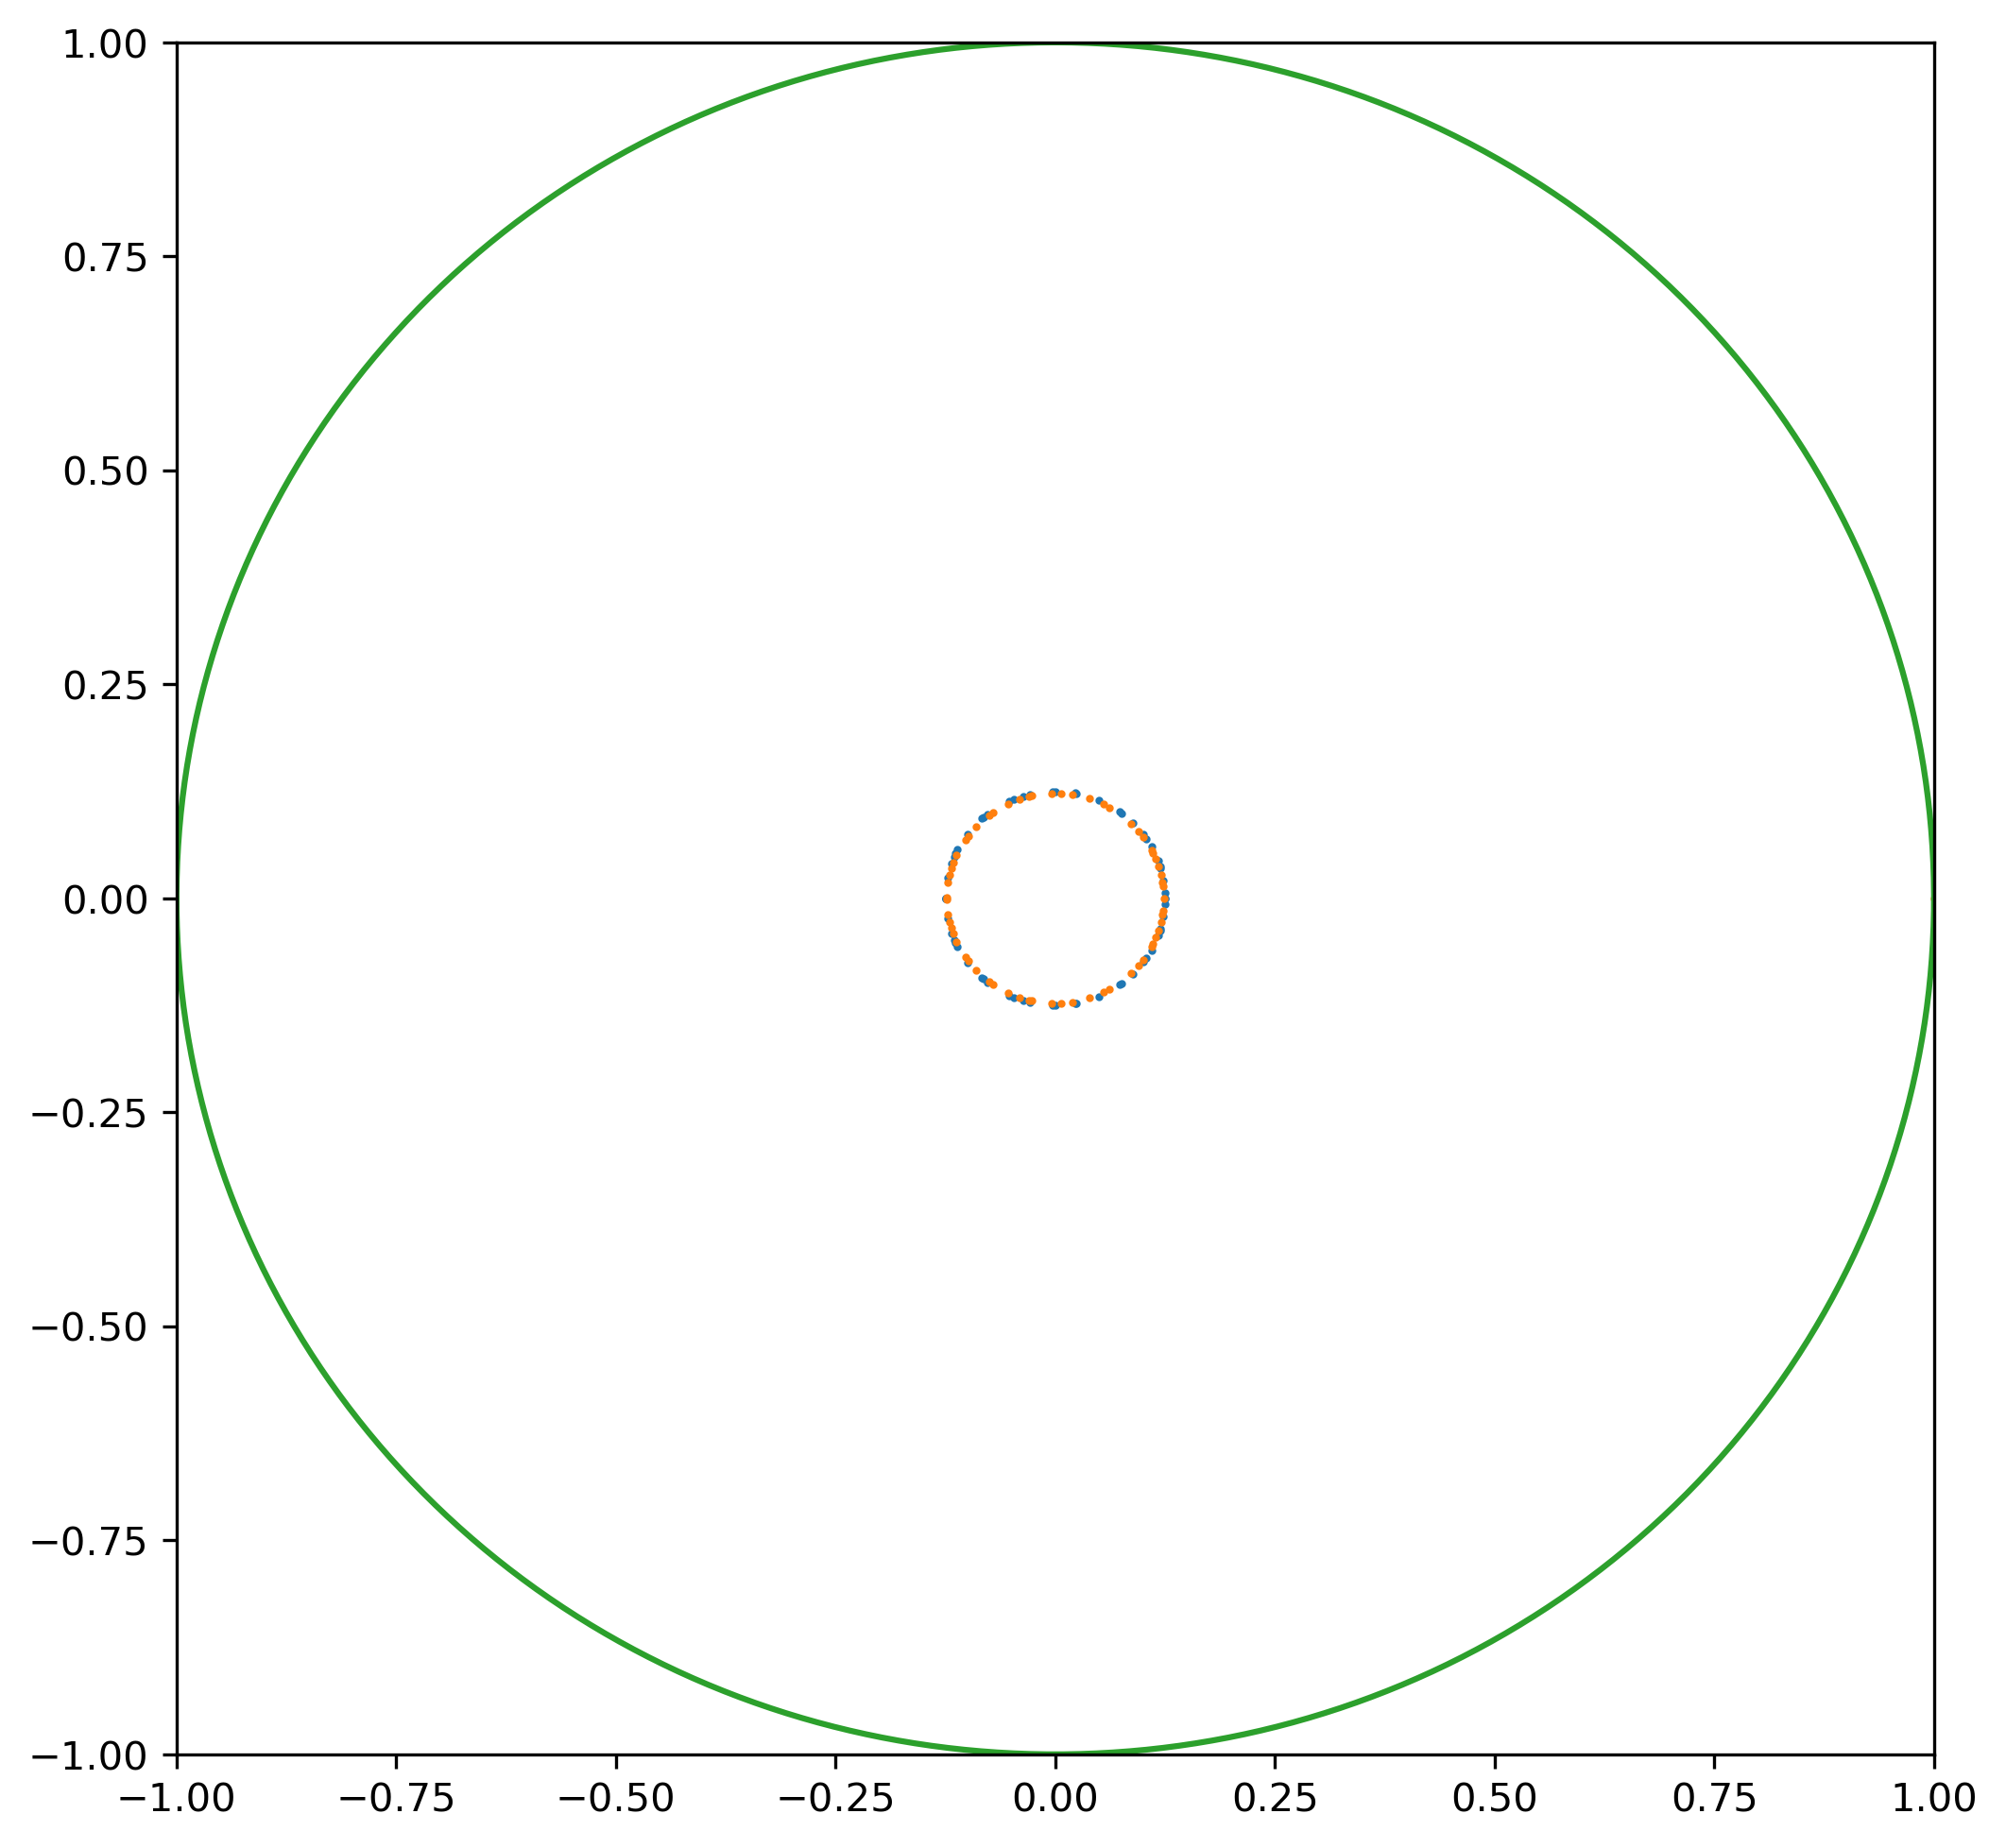

In [37]:
spectrum_model = choi_spectrum(kraus_to_choi(kraus_model))

t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o", markersize=1)
plt.plot(spectrum_model[:,0], spectrum_model[:,1], "o", markersize=1)
plt.plot(*circle)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

In [41]:
print(effective_rank(kraus_model))
print(effective_rank(kraus_target))

tf.Tensor((28.073086023751436+3.116612371005885e-16j), shape=(), dtype=complex128)
tf.Tensor((32.14313513195548-6.494232707436259e-16j), shape=(), dtype=complex128)


## Same Spectra - Different Maps

In [16]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n

kraus_1 = KrausMap(d = d, 
                        rank = d**2)

kraus_2 = KrausMap(d = d, 
                        rank = d**2)

spectrum2 = choi_spectrum(kraus_to_choi(kraus_2))

model_1 = ModelQuantumMap(
                          q_map = kraus_1,
                          loss = RankShrink(inflate=False),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01),
                         )

In [17]:
model_1.train(inputs = [],
            targets = [],
            num_iter = 300,
            N = 1,
            use_batch=False,
            verbose=True,
           )

  0%|          | 0/300 [00:00<?, ?it/s]

Step:0, train: 32.14314, val: 0.00000
Step:1, train: 31.62910, val: 0.00000
Step:2, train: 31.11587, val: 0.00000
Step:3, train: 30.60398, val: 0.00000
Step:4, train: 30.09397, val: 0.00000
Step:5, train: 29.58606, val: 0.00000
Step:6, train: 29.08083, val: 0.00000
Step:7, train: 28.57875, val: 0.00000
Step:8, train: 28.08022, val: 0.00000
Step:9, train: 27.58570, val: 0.00000
Step:10, train: 27.09533, val: 0.00000
Step:11, train: 26.60942, val: 0.00000
Step:12, train: 26.12845, val: 0.00000
Step:13, train: 25.65229, val: 0.00000
Step:14, train: 25.18116, val: 0.00000
Step:15, train: 24.71527, val: 0.00000
Step:16, train: 24.25508, val: 0.00000
Step:17, train: 23.80058, val: 0.00000
Step:18, train: 23.35100, val: 0.00000
Step:19, train: 22.90802, val: 0.00000
Step:20, train: 22.47092, val: 0.00000
Step:21, train: 22.03985, val: 0.00000
Step:22, train: 21.61431, val: 0.00000
Step:23, train: 21.19472, val: 0.00000
Step:24, train: 20.78135, val: 0.00000
Step:25, train: 20.37450, val: 0.00

Step:212, train: 2.53204, val: 0.00000
Step:213, train: 2.52192, val: 0.00000
Step:214, train: 2.51192, val: 0.00000
Step:215, train: 2.50202, val: 0.00000
Step:216, train: 2.49223, val: 0.00000
Step:217, train: 2.48254, val: 0.00000
Step:218, train: 2.47296, val: 0.00000
Step:219, train: 2.46348, val: 0.00000
Step:220, train: 2.45410, val: 0.00000
Step:221, train: 2.44482, val: 0.00000
Step:222, train: 2.43564, val: 0.00000
Step:223, train: 2.42656, val: 0.00000
Step:224, train: 2.41756, val: 0.00000
Step:225, train: 2.40867, val: 0.00000
Step:226, train: 2.39986, val: 0.00000
Step:227, train: 2.39114, val: 0.00000
Step:228, train: 2.38251, val: 0.00000
Step:229, train: 2.37397, val: 0.00000
Step:230, train: 2.36552, val: 0.00000
Step:231, train: 2.35715, val: 0.00000
Step:232, train: 2.34886, val: 0.00000
Step:233, train: 2.34066, val: 0.00000
Step:234, train: 2.33253, val: 0.00000
Step:235, train: 2.32449, val: 0.00000
Step:236, train: 2.31652, val: 0.00000
Step:237, train: 2.30863,

In [18]:
model_1.loss = SpectrumDistance(sigma=1, k=10)
model_1.zero_optimizer()

In [19]:
model_1.train(inputs = [spectrum2],
              targets = [],
              num_iter = 1000,
              N = 1,
              use_batch=False,
              verbose=True,
              )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.16154, val: 0.00000
Step:1, train: 0.18218, val: 0.00000
Step:2, train: 0.20190, val: 0.00000
Step:3, train: 0.22043, val: 0.00000
Step:4, train: 0.23760, val: 0.00000
Step:5, train: 0.25325, val: 0.00000
Step:6, train: 0.26722, val: 0.00000
Step:7, train: 0.27939, val: 0.00000
Step:8, train: 0.28961, val: 0.00000
Step:9, train: 0.29775, val: 0.00000
Step:10, train: 0.30364, val: 0.00000
Step:11, train: 0.30705, val: 0.00000
Step:12, train: 0.30753, val: 0.00000
Step:13, train: 0.30419, val: 0.00000
Step:14, train: 0.30037, val: 0.00000
Step:15, train: 0.30432, val: 0.00000
Step:16, train: 0.30365, val: 0.00000
Step:17, train: 0.29940, val: 0.00000
Step:18, train: 0.29119, val: 0.00000
Step:19, train: 0.28587, val: 0.00000
Step:20, train: 0.28089, val: 0.00000
Step:21, train: 0.27322, val: 0.00000
Step:22, train: 0.26330, val: 0.00000
Step:23, train: 0.26088, val: 0.00000
Step:24, train: 0.26021, val: 0.00000
Step:25, train: 0.26030, val: 0.00000
Step:26, train: 0.2633

Step:214, train: 0.01554, val: 0.00000
Step:215, train: 0.01553, val: 0.00000
Step:216, train: 0.01536, val: 0.00000
Step:217, train: 0.01529, val: 0.00000
Step:218, train: 0.01509, val: 0.00000
Step:219, train: 0.01485, val: 0.00000
Step:220, train: 0.01456, val: 0.00000
Step:221, train: 0.01437, val: 0.00000
Step:222, train: 0.01415, val: 0.00000
Step:223, train: 0.01390, val: 0.00000
Step:224, train: 0.01379, val: 0.00000
Step:225, train: 0.01338, val: 0.00000
Step:226, train: 0.01329, val: 0.00000
Step:227, train: 0.01284, val: 0.00000
Step:228, train: 0.01260, val: 0.00000
Step:229, train: 0.01229, val: 0.00000
Step:230, train: 0.01239, val: 0.00000
Step:231, train: 0.01246, val: 0.00000
Step:232, train: 0.01178, val: 0.00000
Step:233, train: 0.01204, val: 0.00000
Step:234, train: 0.01191, val: 0.00000
Step:235, train: 0.01154, val: 0.00000
Step:236, train: 0.01031, val: 0.00000
Step:237, train: 0.01082, val: 0.00000
Step:238, train: 0.01008, val: 0.00000
Step:239, train: 0.00977,

Step:426, train: 0.00233, val: 0.00000
Step:427, train: 0.00204, val: 0.00000
Step:428, train: 0.00225, val: 0.00000
Step:429, train: 0.00204, val: 0.00000
Step:430, train: 0.00179, val: 0.00000
Step:431, train: 0.00189, val: 0.00000
Step:432, train: 0.00165, val: 0.00000
Step:433, train: 0.00175, val: 0.00000
Step:434, train: 0.00164, val: 0.00000
Step:435, train: 0.00147, val: 0.00000
Step:436, train: 0.00163, val: 0.00000
Step:437, train: 0.00158, val: 0.00000
Step:438, train: 0.00137, val: 0.00000
Step:439, train: 0.00135, val: 0.00000
Step:440, train: 0.00125, val: 0.00000
Step:441, train: 0.00127, val: 0.00000
Step:442, train: 0.00123, val: 0.00000
Step:443, train: 0.00114, val: 0.00000
Step:444, train: 0.00126, val: 0.00000
Step:445, train: 0.00111, val: 0.00000
Step:446, train: 0.00105, val: 0.00000
Step:447, train: 0.00104, val: 0.00000
Step:448, train: 0.00100, val: 0.00000
Step:449, train: 0.00097, val: 0.00000
Step:450, train: 0.00092, val: 0.00000
Step:451, train: 0.00089,

Step:638, train: 0.00117, val: 0.00000
Step:639, train: 0.00076, val: 0.00000
Step:640, train: 0.00088, val: 0.00000
Step:641, train: 0.00088, val: 0.00000
Step:642, train: 0.00068, val: 0.00000
Step:643, train: 0.00086, val: 0.00000
Step:644, train: 0.00062, val: 0.00000
Step:645, train: 0.00102, val: 0.00000
Step:646, train: 0.00126, val: 0.00000
Step:647, train: 0.00094, val: 0.00000
Step:648, train: 0.00079, val: 0.00000
Step:649, train: 0.00098, val: 0.00000
Step:650, train: 0.00070, val: 0.00000
Step:651, train: 0.00097, val: 0.00000
Step:652, train: 0.00056, val: 0.00000
Step:653, train: 0.00063, val: 0.00000
Step:654, train: 0.00074, val: 0.00000
Step:655, train: 0.00051, val: 0.00000
Step:656, train: 0.00061, val: 0.00000
Step:657, train: 0.00048, val: 0.00000
Step:658, train: 0.00049, val: 0.00000
Step:659, train: 0.00048, val: 0.00000
Step:660, train: 0.00069, val: 0.00000
Step:661, train: 0.00085, val: 0.00000
Step:662, train: 0.00056, val: 0.00000
Step:663, train: 0.00054,

Step:849, train: 0.00000, val: 0.00000
Step:850, train: 0.00000, val: 0.00000
Step:851, train: 0.00000, val: 0.00000
Step:852, train: 0.00000, val: 0.00000
Step:853, train: 0.00000, val: 0.00000
Step:854, train: 0.00000, val: 0.00000
Step:855, train: 0.00000, val: 0.00000
Step:856, train: 0.00000, val: 0.00000
Step:857, train: 0.00000, val: 0.00000
Step:858, train: 0.00000, val: 0.00000
Step:859, train: 0.00000, val: 0.00000
Step:860, train: 0.00000, val: 0.00000
Step:861, train: 0.00000, val: 0.00000
Step:862, train: 0.00000, val: 0.00000
Step:863, train: 0.00000, val: 0.00000
Step:864, train: 0.00000, val: 0.00000
Step:865, train: 0.00000, val: 0.00000
Step:866, train: 0.00000, val: 0.00000
Step:867, train: 0.00000, val: 0.00000
Step:868, train: 0.00000, val: 0.00000
Step:869, train: 0.00000, val: 0.00000
Step:870, train: 0.00000, val: 0.00000
Step:871, train: 0.00000, val: 0.00000
Step:872, train: 0.00000, val: 0.00000
Step:873, train: 0.00000, val: 0.00000
Step:874, train: 0.00000,

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


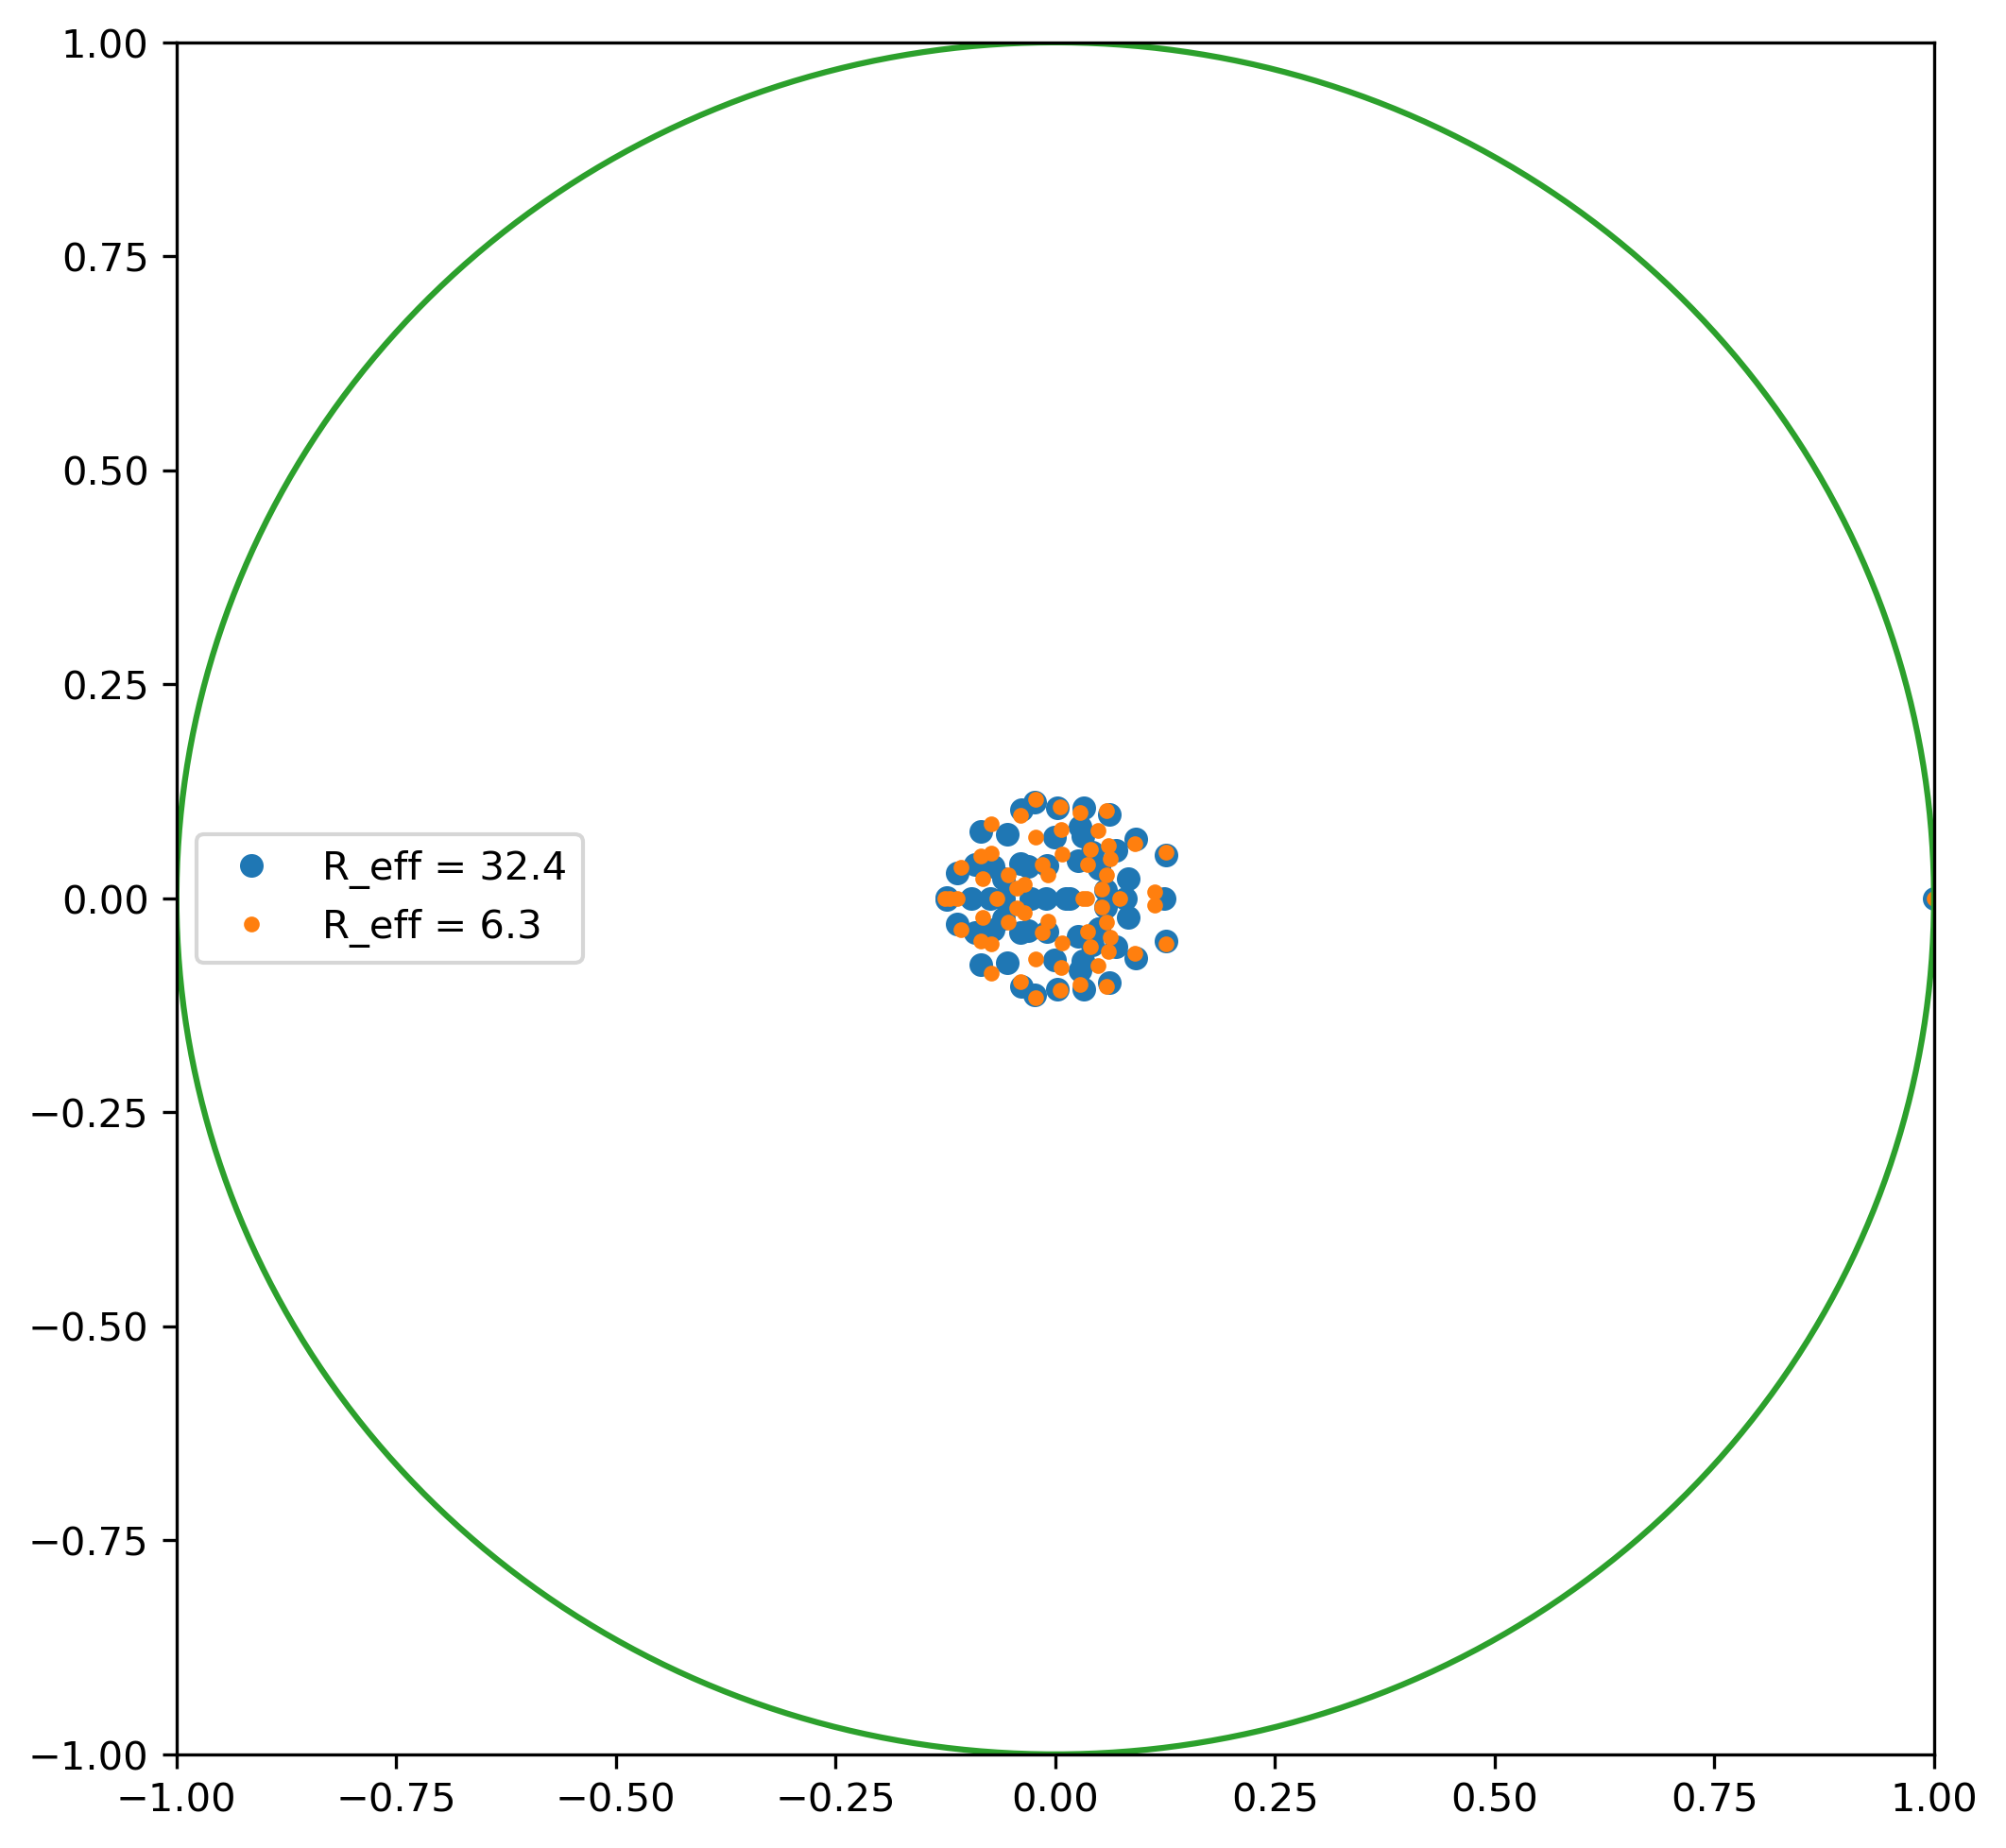

In [20]:
spectrum1 = choi_spectrum(kraus_to_choi(model_1.q_map))

t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
plt.plot(spectrum1[:,0], spectrum1[:,1], "o", markersize=5)
plt.plot(spectrum2[:,0], spectrum2[:,1], "o", markersize=3)
plt.plot(*circle)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.legend(["R_eff = 32.4", "R_eff = 6.3"])
plt.show()

In [24]:
print(effective_rank(model_1.q_map))
print(effective_rank(kraus_2))

tf.Tensor((6.277482172069138-8.800899108339321e-17j), shape=(), dtype=complex128)
tf.Tensor((32.460697629261574-2.2104878644960906e-16j), shape=(), dtype=complex128)


In [25]:
choi = kraus_to_choi(model_1.q_map)
steady_state1 = choi_steady_state(choi)
print(tf.linalg.trace(steady_state1@steady_state1))

choi = kraus_to_choi(kraus_2)
steady_state2 = choi_steady_state(choi)
print(tf.linalg.trace(steady_state2@steady_state2))

tf.Tensor((0.1661049553639308-1.5720931501039814e-18j), shape=(), dtype=complex128)
tf.Tensor((0.12632251332348124-1.5941160067325932e-18j), shape=(), dtype=complex128)


## Fidelity

In [46]:
n = 3
d = 2**n

I = tf.eye(d, d)/d
I = tf.cast(I, dtype = precision)

kraus = KrausMap(d = d, 
                 rank = 10)
print(effective_rank(kraus))

N = 1000
fid_list = []
for i in range(N):
    state = tf.expand_dims(generate_state(d, 1), axis=0)
    state = kraus.apply_map(state)
    fid_list.append(state_fidelity(state, I).numpy())

tau = sum(fid_list)/N    
print(d*tau)

tf.Tensor((8.872924662842365+1.1427358358324913e-16j), shape=(), dtype=complex128)
[6.3012]


## Relation between effective rank and attraction

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 2
d = 2**n

rank_list = np.linspace(d**2, 1, 20)

kraus = KrausMap(d = d, 
                 rank = d**2)


model = ModelQuantumMap(
                        channel = kraus,
                        loss = RankMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

eff_list2 = []
att_list2 = []

In [5]:
for rank in tqdm(rank_list):
    model.train(inputs = [],
                targets = rank,
                num_iter = 500,
                N = 0,
               )

    eff_list2.append(effective_rank(model.channel))
    att_list2.append(attraction(model.channel))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.0019053098923421893


  0%|          | 0/500 [00:00<?, ?it/s]

5.46809651669037e-22


  0%|          | 0/500 [00:00<?, ?it/s]

1.2121952211267991e-23


  0%|          | 0/500 [00:00<?, ?it/s]

9.044287016685714e-24


  0%|          | 0/500 [00:00<?, ?it/s]

1.3828538865194104e-24


  0%|          | 0/500 [00:00<?, ?it/s]

2.5958222757710917e-24


  0%|          | 0/500 [00:00<?, ?it/s]

9.01226235380315e-24


  0%|          | 0/500 [00:00<?, ?it/s]

8.569881935501084e-24


  0%|          | 0/500 [00:00<?, ?it/s]

2.690456494895381e-25


  0%|          | 0/500 [00:00<?, ?it/s]

2.0295939426049123e-24


  0%|          | 0/500 [00:00<?, ?it/s]

5.514718326315268e-24


  0%|          | 0/500 [00:00<?, ?it/s]

3.748975971547446e-26


  0%|          | 0/500 [00:00<?, ?it/s]

7.522375598006796e-24


  0%|          | 0/500 [00:00<?, ?it/s]

7.743213296406995e-24


  0%|          | 0/500 [00:00<?, ?it/s]

6.64805347638314e-24


  0%|          | 0/500 [00:00<?, ?it/s]

5.8491898305634e-24


  0%|          | 0/500 [00:00<?, ?it/s]

2.2384245525397196e-24


  0%|          | 0/500 [00:00<?, ?it/s]

3.3534791434220237e-25


  0%|          | 0/500 [00:00<?, ?it/s]

2.2490678806411633e-24


  0%|          | 0/500 [00:00<?, ?it/s]

0.0007636590383481055


In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n

rank_list = np.linspace(d**2, 1, 20)

kraus = KrausMap(d = d, 
                 rank = d**2)


model = ModelQuantumMap(
                        channel = kraus,
                        loss = RankMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

eff_list3 = []
att_list3 = []

In [9]:
for rank in tqdm(rank_list):
    model.train(inputs = [],
                targets = rank,
                num_iter = 500,
                N = 0,
               )

    eff_list3.append(effective_rank(model.channel))
    att_list3.append(attraction(model.channel))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.3326663741621787


  0%|          | 0/500 [00:00<?, ?it/s]

5.195112704072528e-20


  0%|          | 0/500 [00:00<?, ?it/s]

2.2326655441572548e-23


  0%|          | 0/500 [00:00<?, ?it/s]

7.901235859955075e-23


  0%|          | 0/500 [00:00<?, ?it/s]

1.3579009784404547e-22


  0%|          | 0/500 [00:00<?, ?it/s]

1.6050297761720162e-22


  0%|          | 0/500 [00:00<?, ?it/s]

1.946989493418285e-23


  0%|          | 0/500 [00:00<?, ?it/s]

1.597836373616791e-22


  0%|          | 0/500 [00:00<?, ?it/s]

1.2924635915426259e-26


  0%|          | 0/500 [00:00<?, ?it/s]

4.789408001948965e-24


  0%|          | 0/500 [00:00<?, ?it/s]

5.356175934617387e-25


  0%|          | 0/500 [00:00<?, ?it/s]

1.117105927739019e-22


  0%|          | 0/500 [00:00<?, ?it/s]

5.649013994428884e-24


  0%|          | 0/500 [00:00<?, ?it/s]

1.266749556942921e-22


  0%|          | 0/500 [00:00<?, ?it/s]

9.18083768282541e-23


  0%|          | 0/500 [00:00<?, ?it/s]

2.3337594663189435e-26


  0%|          | 0/500 [00:00<?, ?it/s]

1.623104654169281e-23


  0%|          | 0/500 [00:00<?, ?it/s]

3.692891715540545e-23


  0%|          | 0/500 [00:00<?, ?it/s]

8.700505010609607e-23


  0%|          | 0/500 [00:00<?, ?it/s]

0.08148365779824167


C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


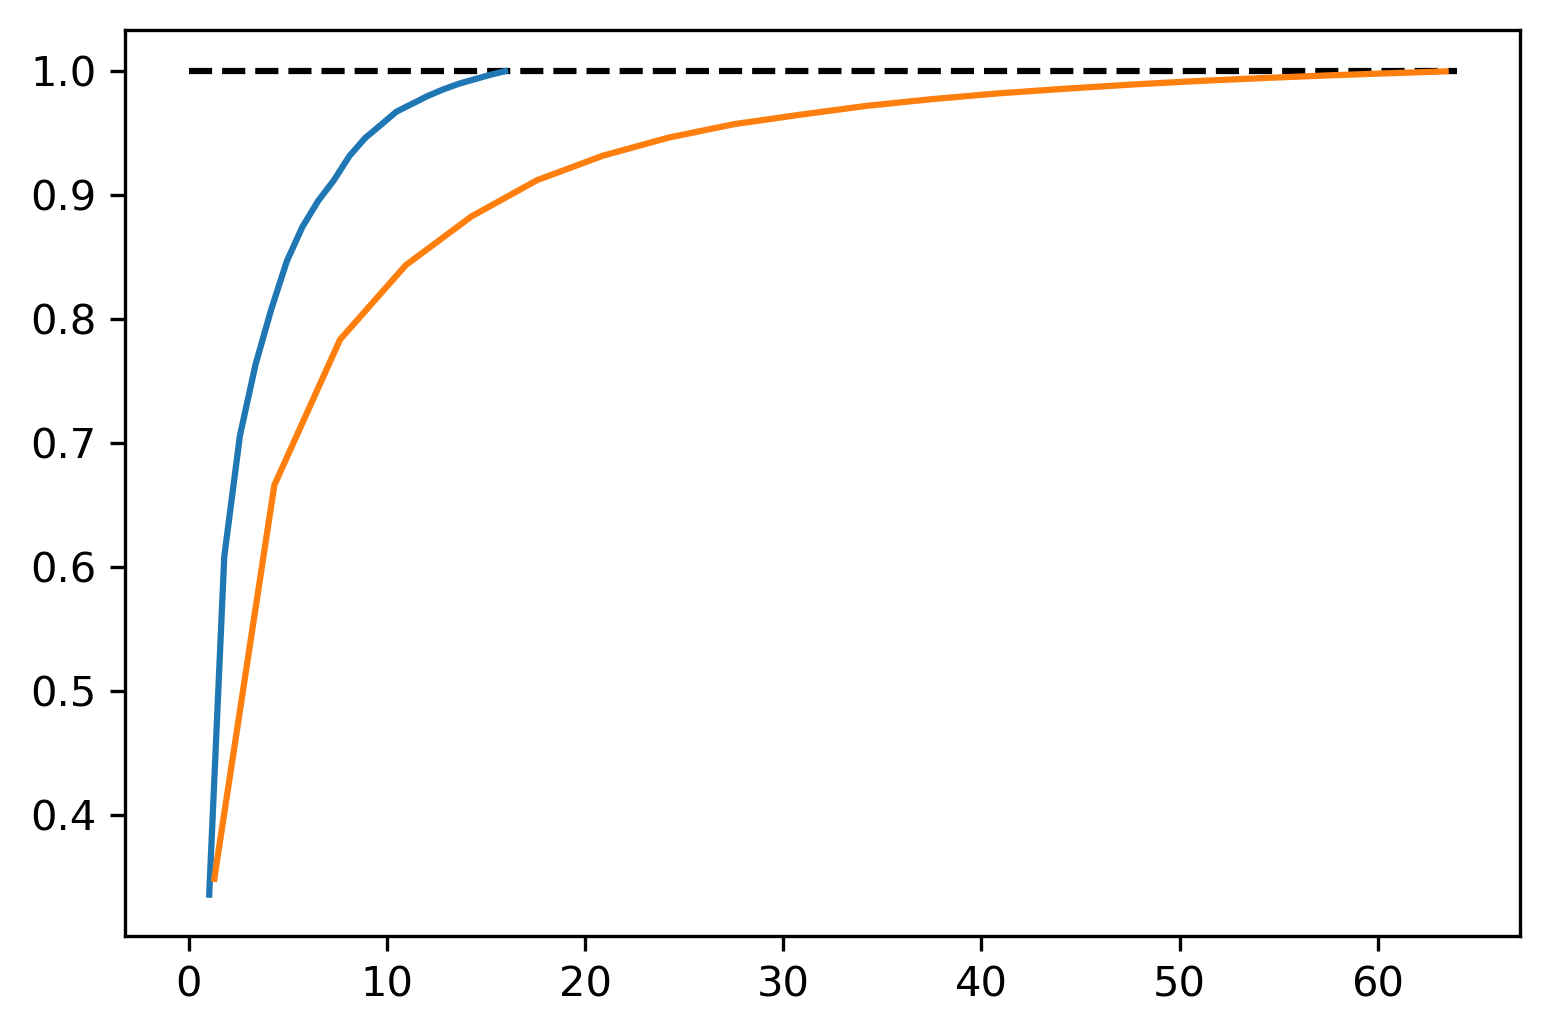

In [10]:
fig=plt.figure(dpi = 300, facecolor='w', edgecolor='k')

plt.plot([0,64], [1,1], "k--")
plt.plot(eff_list2, att_list2)
plt.plot(eff_list3, att_list3)
plt.show()

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 2
d = 2**n

In [4]:
rank_list = np.linspace(16, 1, 20)

eff_rank1 = []
eff_rank2 = []

att1 = []
att2 = []

kraus1 = KrausMap(d = d, 
                  rank = d**2)
kraus2 = KrausMap(d = d, 
                  rank = d**2)

model1 = ModelQuantumMap(
                        channel = kraus1,
                        loss_function = AttractionRankTradeoff(weight=1),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model2 = ModelQuantumMap(
                        channel = kraus2,
                        loss_function = AttractionRankTradeoff(weight=-1),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )


for rank in tqdm(rank_list):

    model1.train(inputs = [],
                targets = [rank],
                num_iter = 3000,
                N = 0,
                )

    model2.train(inputs = [],
                targets = [rank],
                num_iter = 3000,
                N = 0,
                )
    eff_rank1.append(effective_rank(model1.channel))
    eff_rank2.append(effective_rank(model2.channel))
    
    att1.append(attraction(model1.channel))
    att2.append(attraction(model2.channel))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.9999512540735113


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.9998333898214795


  0%|          | 0/3000 [00:00<?, ?it/s]

0.9845732196334904


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.9867842595097003


  0%|          | 0/3000 [00:00<?, ?it/s]

0.9638307195608287


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.9723243000094891


  0%|          | 0/3000 [00:00<?, ?it/s]

0.9350458990857047


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.9562113799410932


  0%|          | 0/3000 [00:00<?, ?it/s]

0.8916095843693896


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.9381208809777762


  0%|          | 0/3000 [00:00<?, ?it/s]

0.7608283460220868


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.917635683779919


  0%|          | 0/3000 [00:00<?, ?it/s]

0.7397054435481321


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.8944009511662208


  0%|          | 0/3000 [00:00<?, ?it/s]

0.72022821856238


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.8676796384759523


  0%|          | 0/3000 [00:00<?, ?it/s]

0.6925629496825361


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.836641344342461


  0%|          | 0/3000 [00:00<?, ?it/s]

0.6496382932523415


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.7997614505031536


  0%|          | 0/3000 [00:00<?, ?it/s]

0.515837950519911


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.7592440654725261


  0%|          | 0/3000 [00:00<?, ?it/s]

0.4929802533025344


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.7171005853317046


  0%|          | 0/3000 [00:00<?, ?it/s]

0.4733397060360776


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.4759998505991787


  0%|          | 0/3000 [00:00<?, ?it/s]

0.4485620845244639


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.4673923177794793


  0%|          | 0/3000 [00:00<?, ?it/s]

0.406765336441712


  0%|          | 0/3000 [00:00<?, ?it/s]

0.6353944503182556


  0%|          | 0/3000 [00:00<?, ?it/s]

0.2783443132390006


  0%|          | 0/3000 [00:00<?, ?it/s]

-0.23155556506014704


  0%|          | 0/3000 [00:00<?, ?it/s]

0.6521910371164734


  0%|          | 0/3000 [00:00<?, ?it/s]

0.14494474678522684


  0%|          | 0/3000 [00:00<?, ?it/s]

2.2726298778413927


  0%|          | 0/3000 [00:00<?, ?it/s]

1.7662590040902588


  0%|          | 0/3000 [00:00<?, ?it/s]

5.140534898842751


  0%|          | 0/3000 [00:00<?, ?it/s]

4.632983012863973


  0%|          | 0/3000 [00:00<?, ?it/s]

9.253415283862692


  0%|          | 0/3000 [00:00<?, ?it/s]

8.747528105951158


In [5]:
pickle.dump([eff_rank1, eff_rank2, att1, att2], open("../../data/effective_rank_vs_attraction.p", "wb"))

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


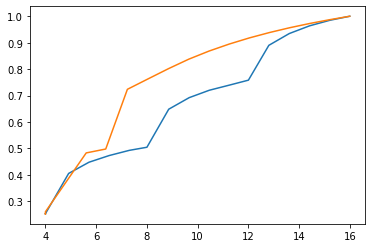

In [6]:
plt.plot(eff_rank1, att1)
plt.plot(eff_rank2, att2)

In [10]:
n = 3
d = 2**n

kraus1 = KrausMap(d = d, 
                  rank = d**2)
kraus2 = KrausMap(d = d, 
                  rank = d**2)

model1 = ModelQuantumMap(
                        channel = kraus1,
                        loss_function = AttractionRankTradeoff(weight=1),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model2 = ModelQuantumMap(
                        channel = kraus2,
                        loss_function = AttractionRankTradeoff(weight=-1),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )


model1.train(inputs = [],
             targets = [4],
             num_iter = 500,
             N = 0,
            )

model2.train(inputs = [],
            targets = [4],
            num_iter = 500,
            N = 0,
            )

  0%|          | 0/500 [00:00<?, ?it/s]

Step:0, train: 810.0113384161097
Step:1, train: 781.8575214496848
Step:2, train: 754.261773183667
Step:3, train: 727.2530352141821
Step:4, train: 700.8554386729388
Step:5, train: 675.0891849657824
Step:6, train: 649.9730538882576
Step:7, train: 625.5209753439159
Step:8, train: 601.7433363412053
Step:9, train: 578.6476257254957
Step:10, train: 556.2362476524282
Step:11, train: 534.5106011519281
Step:12, train: 513.468253458767
Step:13, train: 493.10563743244336
Step:14, train: 473.4167769989276
Step:15, train: 454.39502303401486
Step:16, train: 436.03146452300655
Step:17, train: 418.31626580527404
Step:18, train: 401.2375178871419
Step:19, train: 384.7853107500001
Step:20, train: 368.94446838644006
Step:21, train: 353.7034207794669
Step:22, train: 339.0482519964417
Step:23, train: 324.9628101167722
Step:24, train: 311.4340198272728
Step:25, train: 298.4455038285961
Step:26, train: 285.9831445660313
Step:27, train: 274.0309382287625
Step:28, train: 262.5746739789237
Step:29, train: 251.5

Step:236, train: 3.059902321063357
Step:237, train: 3.0343439565876147
Step:238, train: 3.00241011709578
Step:239, train: 2.972201871209071
Step:240, train: 2.9437533231468427
Step:241, train: 2.915528153117017
Step:242, train: 2.887771593113933
Step:243, train: 2.861025602266605
Step:244, train: 2.8339869405755254
Step:245, train: 2.8036921882176262
Step:246, train: 2.7784934970392303
Step:247, train: 2.752842251207188
Step:248, train: 2.7292357286242166
Step:249, train: 2.7026194745342367
Step:250, train: 2.6743170896216757
Step:251, train: 2.6531699973478546
Step:252, train: 2.6269971077625724
Step:253, train: 2.602275913153259
Step:254, train: 2.581531119933
Step:255, train: 2.55750158739093
Step:256, train: 2.5363273639418917
Step:257, train: 2.5145614937394543
Step:258, train: 2.49130531078047
Step:259, train: 2.4693825239984672
Step:260, train: 2.4464416058538
Step:261, train: 2.4294562629600462
Step:262, train: 2.4045387731356618
Step:263, train: 2.3854584137403556
Step:264, tr

Step:466, train: 0.9040316762722105
Step:467, train: 0.9051356075275658
Step:468, train: 0.9014198833150948
Step:469, train: 0.9029487003699814
Step:470, train: 0.9025710266043007
Step:471, train: 0.8954706543455824
Step:472, train: 0.8945041415201755
Step:473, train: 0.8963629023429242
Step:474, train: 0.8898701000656435
Step:475, train: 0.8888781928044139
Step:476, train: 0.8897819629658967
Step:477, train: 0.8833641979465708
Step:478, train: 0.8829088101146808
Step:479, train: 0.8856486878704941
Step:480, train: 0.8804781070177574
Step:481, train: 0.8801969544886397
Step:482, train: 0.8786061099943434
Step:483, train: 0.8776927059036153
Step:484, train: 0.8773376046320784
Step:485, train: 0.875728151469662
Step:486, train: 0.87279133850735
Step:487, train: 0.8727139839765531
Step:488, train: 0.8697643380005908
Step:489, train: 0.8696014815376083
Step:490, train: 0.8673714520311986
Step:491, train: 0.8645449851162659
Step:492, train: 0.8653492234550301
Step:493, train: 0.863232005178

  0%|          | 0/500 [00:00<?, ?it/s]

Step:0, train: 806.6528567020088
Step:1, train: 777.2632123936709
Step:2, train: 748.4914093973432
Step:3, train: 720.3711364019044
Step:4, train: 692.9290162127145
Step:5, train: 666.1854117924802
Step:6, train: 640.1548985115792
Step:7, train: 614.8465627217056
Step:8, train: 590.2684610927677
Step:9, train: 566.4226661553101
Step:10, train: 543.3095255674821
Step:11, train: 520.9273641639928
Step:12, train: 499.27117591657566
Step:13, train: 478.3349802523239
Step:14, train: 458.11062754099663
Step:15, train: 438.588856752297
Step:16, train: 419.75930348548957
Step:17, train: 401.6079053195767
Step:18, train: 384.12530616766367
Step:19, train: 367.29485094359563
Step:20, train: 351.10278130576245
Step:21, train: 335.533716690764
Step:22, train: 320.5737286002456
Step:23, train: 306.2026790417712
Step:24, train: 292.4090126682329
Step:25, train: 279.17403396927523
Step:26, train: 266.4827222112884
Step:27, train: 254.31765070704935
Step:28, train: 242.66414664726238
Step:29, train: 2

Step:235, train: 0.4491208646961268
Step:236, train: 0.43248035054034584
Step:237, train: 0.4181770243709312
Step:238, train: 0.3956728655346623
Step:239, train: 0.3853481255350727
Step:240, train: 0.3658028657240677
Step:241, train: 0.35203500173073543
Step:242, train: 0.3359934810208234
Step:243, train: 0.31883655553569634
Step:244, train: 0.3059174008975035
Step:245, train: 0.2884879724426985
Step:246, train: 0.273123551398743
Step:247, train: 0.26044091744389475
Step:248, train: 0.24855677816264388
Step:249, train: 0.2312071500601821
Step:250, train: 0.21900214069816504
Step:251, train: 0.2046902681019841
Step:252, train: 0.1932587573301865
Step:253, train: 0.1771288012388218
Step:254, train: 0.16455979818288868
Step:255, train: 0.1527277598225013
Step:256, train: 0.1405917368898364
Step:257, train: 0.1260696206777978
Step:258, train: 0.11453451564189654
Step:259, train: 0.10372906774449842
Step:260, train: 0.0901267830257293
Step:261, train: 0.07722381706510628
Step:262, train: 0.

Step:456, train: -0.6918642558119584
Step:457, train: -0.6941667156821846
Step:458, train: -0.69168233198175
Step:459, train: -0.6935066846053347
Step:460, train: -0.7002554870180308
Step:461, train: -0.698821409419293
Step:462, train: -0.6980923157804577
Step:463, train: -0.6978577489282547
Step:464, train: -0.697956239661506
Step:465, train: -0.701649577957267
Step:466, train: -0.7010142502199761
Step:467, train: -0.6982986520406976
Step:468, train: -0.7045040388601886
Step:469, train: -0.7026936038505119
Step:470, train: -0.7031042979745513
Step:471, train: -0.7047922421677807
Step:472, train: -0.7081655348853756
Step:473, train: -0.7046342031230549
Step:474, train: -0.7038806589144425
Step:475, train: -0.7066634642676376
Step:476, train: -0.7065464861994408
Step:477, train: -0.7092402486342382
Step:478, train: -0.7086862597843749
Step:479, train: -0.7097326240356535
Step:480, train: -0.709691427041925
Step:481, train: -0.7096037936424184
Step:482, train: -0.7109758667852714
Step:48

In [11]:
print(effective_rank(model1.channel), attraction(model1.channel))
print(effective_rank(model2.channel), attraction(model2.channel))

tf.Tensor((4.328101141862171-2.0780398895443688e-17j), shape=(), dtype=complex128) tf.Tensor(0.7447308790373779, shape=(), dtype=float64)
tf.Tensor((4.204623119829187+9.52363144306285e-17j), shape=(), dtype=complex128) tf.Tensor(0.7623794223384268, shape=(), dtype=float64)
